<a href="https://colab.research.google.com/github/nakatoconstance/MDR2020_2021/blob/main/MDR_2020_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import FileLink


In [2]:
import pandas as pd
import numpy as np
# Load the data
from google.colab import files
uploaded = files.upload()
np.random.seed(0)


Saving MUST_MDR_DATA_final_MERGED_final.csv to MUST_MDR_DATA_final_MERGED_final.csv


In [ ]:
#load dataframe
data = pd.read_csv('MUST_MDR_DATA_final_MERGED_final.csv', encoding='latin-1')
data.head()

In [4]:
import pandas as pd

# Step 1: Define clean urine specimen terms
allowed_urine = ['ur', 'urine', 'msu', 'uc', 'ue', 'ur.']

# Step 2: Filter the DataFrame for allowed urine samples
filtered_data = data[data['Specimen type'].isin(allowed_urine)]

# Step 3: Count occurrences in the filtered data
counts_allowed_urine = filtered_data['Specimen type'].value_counts()

# Step 4: Print the counts
print(counts_allowed_urine)

Specimen type
ur       5354
ue        152
uc         94
urine       6
msu         2
ur.         1
Name: count, dtype: int64


In [5]:
import pandas as pd

# Step 1: Define clean urine specimen terms
allowed_urine = ['ur', 'urine', 'msu', 'uc', 'ue', 'ur.']

# Step 2: Clean 'Specimen type' column
data['Specimen type'] = data['Specimen type'].astype(str).str.strip().str.lower()

# Step 3: Filter for clean urine samples
urine_all = data[data['Specimen type'].isin(allowed_urine)].copy()

# Step 4: Flag *Staphylococcus aureus* entries (e.g., 'sau', 'saj')
urine_all['Flagged_for_review'] = urine_all['Organism'].str.lower().isin(['sau', 'saj'])

# Step 5: Define organism groups
true_uropathogens = [
    'eco', 'kpn', 'kl', 'kl-', 'koz', 'kox', 'eae', 'ent', 'efa', 'ecl',
    'esc', 'prv', 'pmi', 'pvu', 'sma', 'cfr', 'ci-', 'mmo'
]
conditional_uropathogens = [
    'ps-', 'pae', 'xpa', 'aba', 'ac-', 'xgo', 'xsg', 'svi', 'ecc',
    'ecx', 'pr-', 'ne-', 'ngo'
]
contaminants_or_non_uropathogens = [
    'nan', 'xxx', 'can', 'cal', 'cac', 'sta', 'scn', 'sc+', 'con',
    'cgu', 'cci', 'spn', 'str', 'ssa', 'oth', 'gnr'
]

# Step 6: Add column to classify organism type
organism_col = 'Organism'
urine_all['Organism'] = urine_all[organism_col].astype(str).str.lower().str.strip()

def classify_org(code):
    if code in true_uropathogens:
        return 'keep'
    elif code in conditional_uropathogens:
        return 'flag'
    else:
        return 'exclude'

urine_all['Organism_group'] = urine_all['Organism'].apply(classify_org)

# Step 7: Final filtered dataset (only true uropathogens, exclude all else)
urine_data = urine_all[urine_all['Organism_group'] == 'keep'].copy()

# Step 8: Save the clean dataset
urine_data.to_csv('urine_data.csv', index=False)

print("✅ Saved: Final clean dataset with true uropathogens as 'urine_data.csv'")


✅ Saved: Final clean dataset with true uropathogens as 'urine_data.csv'


In [6]:
#count number of raws
print(len(urine_data))

1460


In [7]:
#print unique organisms
print(urine_data['Organism'].unique())

['eco' 'kl-' 'ent' 'eae' 'kpn' 'esc' 'efa' 'cfr' 'mmo' 'pmi' 'ecl' 'prv'
 'kl' 'koz' 'kox' 'ci-' 'pvu' 'sma']


In [8]:
#print counts for each organism
print(urine_data['Organism'].value_counts())

Organism
kl-    660
eco    567
kpn     82
ci-     55
ent     29
cfr     14
kox     14
eae      8
efa      7
prv      5
mmo      4
pmi      4
pvu      4
kl       2
sma      2
esc      1
koz      1
ecl      1
Name: count, dtype: int64


In [9]:
#remove duplicates
urine_data = urine_data.drop_duplicates()

In [10]:
# Ensure correct date parsing (dayfirst=True for dd/mm/yyyy format)
data['Specimen date'] = pd.to_datetime(data['Specimen date'], errors='coerce', dayfirst=True)

# Sort the dataframe by 'Specimen date'
data.sort_values(by='Specimen date', inplace=True)

# Forward-fill missing dates
#data['Specimen date'] = data['Specimen date'].ffill()
data['Specimen date'] = data['Specimen date'].interpolate(method='linear')  # Example
# Now the data is correctly sorted and missing dates are filled with forward filling


In [11]:
#check unique specimen
unique_specimen = urine_data['Specimen type'].unique()
print(unique_specimen)

['ur' 'uc' 'ue' 'urine']


In [12]:
#check unique organisms
unique_organisms = urine_data['Organism'].unique()
print(unique_organisms)

['eco' 'kl-' 'ent' 'eae' 'kpn' 'esc' 'efa' 'cfr' 'mmo' 'pmi' 'ecl' 'prv'
 'kl' 'koz' 'kox' 'ci-' 'pvu' 'sma']


In [13]:
# STEP 0: Apply “one isolate per patient per year” rule

# Convert 'Specimen date' to datetime and extract year
urine_data['Specimen date'] = pd.to_datetime(urine_data['Specimen date'], errors='coerce')
urine_data['Year'] = urine_data['Specimen date'].dt.year

# Build composite ID for cases with missing official ID
urine_data['ID_fallback'] = urine_data['Identification number'].fillna(
    urine_data['Last name'].astype(str).str.upper() + "_" +
    urine_data['First name'].astype(str).str.upper() + "_" +
    urine_data['Sex'].astype(str).str.upper() + "_" +
    urine_data['Date of Birth'].astype(str)
)

# Keep only one isolate per patient per year
urine_data = urine_data.sort_values(by='Specimen date')
urine_data = urine_data.drop_duplicates(subset=['ID_fallback', 'Year'], keep='first')

<ipython-input-13-d13c5e2f90c1>:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  urine_data['Specimen date'] = pd.to_datetime(urine_data['Specimen date'], errors='coerce')


In [14]:
print(urine_data['Organism'].value_counts())


Organism
kl-    571
eco    541
kpn     78
ci-     53
ent     29
cfr     14
kox     13
eae      8
efa      7
prv      5
mmo      4
pmi      4
pvu      2
sma      2
kl       2
koz      1
ecl      1
esc      1
Name: count, dtype: int64


In [15]:
# Step: Define code-to-organism mapping dictionary
organism_mapping = {
    'eco': 'Escherichia coli',
    'kl-': 'Klebsiella spp.',
    'ent': 'Enterococcus spp.',
    'eae': 'Enterobacter aerogenes',
    'kpn': 'Klebsiella pneumoniae',
    'esc': 'Enterobacter spp.',
    'efa': 'Enterococcus faecalis',
    'cfr': 'Citrobacter freundii',
    'mmo': 'Morganella morganii',
    'pmi': 'Proteus mirabilis',
    'ecl': 'Enterobacter cloacae',
    'prv': 'Providencia spp.',
    'kl':  'Klebsiella spp.',
    'koz': 'Klebsiella oxytoca',
    'kox': 'Klebsiella oxytoca',
    'ci-': 'Citrobacter spp.',
    'pvu': 'Proteus vulgaris',
    'sma': 'Serratia marcescens'
}

# Step: Clean and map organism codes
urine_data['Organism'] = urine_data['Organism'].astype(str).str.lower().str.strip()
urine_data['Organism_full'] = urine_data['Organism'].map(organism_mapping)

# Optional: Flag unmapped codes (for review or data quality checks)
urine_data['Unmapped_Organism'] = urine_data['Organism_full'].isna()


In [16]:
#unique organisms
# First, if the original 'Organism' column still exists and is not needed, drop it
if 'Organism' in urine_data.columns:
    urine_data = urine_data.drop(columns=['Organism'])

# Then, rename the 'Organism_full' column to 'Organism'
urine_data = urine_data.rename(columns={'Organism_full': 'Organism'})
print(urine_data['Organism'].unique())

['Klebsiella pneumoniae' 'Escherichia coli' 'Klebsiella spp.'
 'Serratia marcescens' 'Enterococcus faecalis' 'Enterobacter aerogenes'
 'Citrobacter freundii' 'Klebsiella oxytoca' 'Proteus vulgaris'
 'Citrobacter spp.' 'Proteus mirabilis' 'Providencia spp.'
 'Morganella morganii' 'Enterobacter cloacae' 'Enterococcus spp.'
 'Enterobacter spp.']


In [17]:
#Lets get values from 2018 on wards

urine_data = urine_data[(urine_data['Specimen date'] >= '2019') & (urine_data['Specimen date'] < '2025-01-01')]

#Total number of recods
print(len(urine_data))

1156


In [18]:
#Full counts for each organism in table
organism_counts = urine_data['Organism'].value_counts()
print(organism_counts)

Organism
Escherichia coli          498
Klebsiella spp.           443
Klebsiella pneumoniae      73
Citrobacter spp.           53
Enterococcus spp.          29
Citrobacter freundii       14
Klebsiella oxytoca         14
Enterobacter aerogenes      8
Enterococcus faecalis       6
Providencia spp.            5
Morganella morganii         4
Proteus mirabilis           4
Proteus vulgaris            2
Serratia marcescens         1
Enterobacter cloacae        1
Enterobacter spp.           1
Name: count, dtype: int64


In [19]:
#display unique departments
print(urine_data['Department'].unique())

['opd' 'med' 'mat' 'ISS' 'pri' nan 'obg' 'ant' 'sur' 'eme' 'mch' 'priv'
 'ped' 'icu' 'neurol' 'mst' 'ICU' 'M/E' 'onc p' 'diabetic cl' 'MCH'
 'UR/CL' 'STI' 'ONC' 'Neuro' 'eqa' 'CCP' 'opd gyn' 'OPD GYN']


In [20]:
#start and end date
print(urine_data['Specimen date'].min())
print(urine_data['Specimen date'].max())

2019-04-01 00:00:00
2024-12-11 00:00:00


In [21]:
# Normalize department names
urine_data['Department_clean'] = urine_data['Department'].astype(str).str.lower().str.strip()

# Define Klebsiella organisms
klebsiella_labels = ['Klebsiella spp.', 'Klebsiella pneumoniae', 'Klebsiella oxytoca']

# Filter: OPD + Klebsiella
opd_klebsiella = urine_data[
    urine_data['Department_clean'].str.contains('opd', na=False) &
    urine_data['Organism'].isin(klebsiella_labels)
]

# Count each Klebsiella species in OPD
opd_kleb_counts = opd_klebsiella['Organism'].value_counts()
print(opd_kleb_counts)

# Optional: Total Klebsiella in OPD
print(f"\nTotal Klebsiella isolates in OPD: {opd_klebsiella.shape[0]}")


Organism
Klebsiella spp.          351
Klebsiella pneumoniae     38
Klebsiella oxytoca         8
Name: count, dtype: int64

Total Klebsiella isolates in OPD: 397


In [22]:
# Count E. coli in OPD
eco_opd = urine_data[
    (urine_data['Department_clean'].str.contains('opd', na=False)) &
    (urine_data['Organism'] == 'Escherichia coli')
]

print(f"E. coli in OPD: {eco_opd.shape[0]}")


E. coli in OPD: 319


In [23]:
#count missing dates
missing_dates = urine_data['Specimen date'].isnull().sum()
print(f"Number of missing dates: {missing_dates}")


Number of missing dates: 0


In [24]:
#count organisms per specimen
specimen_counts = urine_data['Specimen type'].value_counts()
print(specimen_counts)


Specimen type
ur       1115
uc         27
ue         12
urine       2
Name: count, dtype: int64


In [25]:
print(urine_data['Organism'].unique())


['Klebsiella spp.' 'Serratia marcescens' 'Escherichia coli'
 'Enterobacter aerogenes' 'Citrobacter freundii' 'Klebsiella oxytoca'
 'Klebsiella pneumoniae' 'Proteus vulgaris' 'Citrobacter spp.'
 'Proteus mirabilis' 'Providencia spp.' 'Morganella morganii'
 'Enterococcus faecalis' 'Enterobacter cloacae' 'Enterococcus spp.'
 'Enterobacter spp.']


In [26]:
# Define the column name replacements
column_name_mapping = {

    'AMX_ND25': 'Amoxicillin',
    'AMC_ND20': 'Amoxicillin/Clavulanic Acid',
    'AMK_ND30': 'Amikacin',
    'AMP_ND10': 'Ampicillin',
    'AZM_ND15': 'Azithromycin',
    'FEP_ND30': 'Cefepime',
    'BAC_ND10': 'Bacitracin',
    'CRO_ND30': 'Ceftriaxone',
    'CXM_ND30': 'Cefuroxime',
    'CIP_ND5': 'Ciprofloxacin',
    'OXA_ND1': 'Oxacillin',
    'CHL_ND30': 'Chloramphenicol',
    'CZO_ND30': 'Cefazolin',
    'CLI_ND2': 'Clindamycin',
    'GEN_ND10': 'Gentamicin',
    'GEH_ND120': 'Gentaheptose',
    'ERY_ND15': 'Erythromycin',
    'TCY_ND30': 'Tetracycline',
    'RIF_ND5': 'Rifampicin',
    'SAM_ND10': 'Ampicillin/Sulbactam',
    'OFX_ND5': 'Ofloxacin',
    'SXT_ND12': 'Sulfamethoxazole',  # corrected spelling
    'TOB_ND10': 'Tobramycin',
    'OPT_ND5': 'Optochin',
    'MFX_ND5': 'Moxifloxacin',
    'VAN_ND30': 'Vancomycin',
    'PEN_ND10': 'Penicillin',
    'NAL_ND30': 'Nalidixic Acid',
    'IPM_ND10': 'Imipenem',
    'CAC_ND30': 'Cefaclor',
    'CAZ_ND30': 'Ceftazidime',
    'LVX_ND5': 'Levofloxacin',
    'NIT_ND300': 'Nitrofurantoin',
    'CTC_ND30': 'Chlortetracycline',
    'CTX_ND30': 'Cefotaxime',
    'ATM_ND30': 'Aztreonam',
    'AZL_ND75': 'Azlocillin',
    'CFM_ND5': 'Cefixime',
    'FOX_ND30': 'Cefoxitin 30 mg',  # made unique
    'FOX_ND10': 'Cefoxitin 10 mg',  # made unique
    'DOX_ND30': 'Doxycycline',
    'LNZ_ND30': 'Linezolid',
    'MEM_ND10': 'Meropenem',
    'MET_ND5': 'Metronidazole',
    'PIP_ND100': 'Piperacillin',
    'CCV_ND30': 'Cefovecin',
    'NOV_ND5': 'Novobiocin',
    'PEF_ND10': 'Pefloxacin',
    'NOR_ND5': 'Norfloxacin'
}

# Get existing columns in the DataFrame
existing_columns = urine_data.columns

# Filter the mapping to only include existing columns
filtered_mapping = {k: v for k, v in column_name_mapping.items() if k in existing_columns}

# Replace the column names
urine_data = urine_data.rename(columns=filtered_mapping)

In [27]:
#droping missing organisms
urine_data = urine_data.dropna(subset=['Organism'])

In [28]:
#check total number of records
print(len(urine_data))

1156


In [29]:
# Check the unique values in the 'Sex' column
print(urine_data['Sex'].unique())

# Check the data type of the 'Sex' column
print(urine_data['Sex'].dtype)
#count columns with nan or -
nan_count = urine_data['Sex'].isna().sum()
print("Number of NaN values in 'Sex' column:", nan_count)


['f' 'm' nan]
object
Number of NaN values in 'Sex' column: 5


In [30]:
#droping sex with  '-'
urine_data = urine_data[urine_data['Sex'] != '-']
#droping unknown sex
urine_data=urine_data.dropna(subset=['Sex'])


In [31]:
# Select columns 8 to 31
columns_to_encode = urine_data.columns[28:78]

# One-hot encode, handling only I, R, and S
data_encoded = pd.DataFrame()
for col in columns_to_encode:
    temp_df = pd.get_dummies(urine_data[col], prefix=col)  # Encode all values
    value_mapping = {'I': col + '_I', 'R': col + '_R', 'S': col + '_S'}
    desired_columns = [value_mapping[val] for val in value_mapping if value_mapping[val] in temp_df.columns]
    if desired_columns:
        temp_df = temp_df[desired_columns]
        data_encoded = pd.concat([data_encoded, temp_df], axis=1)

# Concatenate encoded columns with original DataFrame
urine_data = pd.concat([urine_data, data_encoded], axis=1)

# Change datatype of encoded columns to int and impute missing values
encoded_column_names = data_encoded.columns.tolist()
urine_data[encoded_column_names] = urine_data[encoded_column_names].fillna(0).astype(int)  # Fill NaN first

print(encoded_column_names)  # Display the encoded column names

['Amoxicillin/Clavulanic Acid_I', 'Amoxicillin/Clavulanic Acid_R', 'Amoxicillin/Clavulanic Acid_S', 'Amikacin_I', 'Amikacin_R', 'Amikacin_S', 'Ampicillin_I', 'Ampicillin_R', 'Ampicillin_S', 'Azithromycin_I', 'Azithromycin_R', 'Azithromycin_S', 'Cefepime_R', 'Cefepime_S', 'Ceftriaxone_I', 'Ceftriaxone_R', 'Ceftriaxone_S', 'Cefuroxime_I', 'Cefuroxime_R', 'Cefuroxime_S', 'Ciprofloxacin_I', 'Ciprofloxacin_R', 'Ciprofloxacin_S', 'Oxacillin_R', 'Oxacillin_S', 'Chloramphenicol_I', 'Chloramphenicol_R', 'Chloramphenicol_S', 'Cefazolin_I', 'Cefazolin_R', 'Cefazolin_S', 'Clindamycin_I', 'Clindamycin_R', 'Clindamycin_S', 'Gentamicin_I', 'Gentamicin_R', 'Gentamicin_S', 'Gentaheptose_I', 'Gentaheptose_S', 'Erythromycin_I', 'Erythromycin_R', 'Erythromycin_S', 'Tetracycline_I', 'Tetracycline_R', 'Tetracycline_S', 'Rifampicin_R', 'Rifampicin_S', 'Ofloxacin_R', 'Ofloxacin_S', 'Sulfamethoxazole_I', 'Sulfamethoxazole_R', 'Sulfamethoxazole_S', 'Moxifloxacin_I', 'Moxifloxacin_R', 'Moxifloxacin_S', 'Vancomyc

In [32]:
#droping original columns
# Assuming 'columns_to_encode' contains the names of original columns you encoded:
urine_data = urine_data.drop(columns=columns_to_encode)

In [33]:
urine_data['Specimen date'] = pd.to_datetime(urine_data['Specimen date'], dayfirst=True)
#urine_data['Specimen date'] = data['Specimen date'].interpolate(method='linear')  # Example

In [34]:
# Check for NaN values in encoded columns
nan_values = urine_data[encoded_column_names].isna().sum()
print(nan_values)

Amoxicillin/Clavulanic Acid_I    0
Amoxicillin/Clavulanic Acid_R    0
Amoxicillin/Clavulanic Acid_S    0
Amikacin_I                       0
Amikacin_R                       0
                                ..
Pefloxacin_S                     0
Norfloxacin_R                    0
Norfloxacin_S                    0
Ceftazidime_R                    0
Ceftazidime_S                    0
Length: 114, dtype: int64


In [35]:
print(urine_data[encoded_column_names].head(10))  # Check the first 10 rows of encoded columns
#print(data.info())  # Get summary information about the DataFrame

      Amoxicillin/Clavulanic Acid_I  Amoxicillin/Clavulanic Acid_R  \
6244                              0                              0   
6176                              0                              0   
6167                              0                              0   
6133                              0                              0   
6115                              0                              0   
5903                              0                              0   
5900                              0                              0   
5832                              0                              0   
5828                              0                              0   
5808                              0                              0   

      Amoxicillin/Clavulanic Acid_S  Amikacin_I  Amikacin_R  Amikacin_S  \
6244                              0           0           0           1   
6176                              0           0           0           0   
6167

In [36]:
#check empty age columns
missing_data = urine_data['Age'].isnull().sum()
print(missing_data)
#show unique age
print(urine_data['Age'].unique())

38
['2' nan '42' '75' '33' '34' '45' '73' '50' '9' '26' '25' '43' '58' '21'
 '37' '29' '23' '38' '18' '69' '24' '70' '67' '20' '41' '47' '44' '32'
 '31' '86' '36' '40' '61' '87' '28' '60' '48' '30' '10' '22' '35' '27'
 '51' '46' '84' '53' '66' '16' '63' '4' '72' '11' '49' '5' '19' '52' '92'
 '39' '78' '88' '13' '57' '6' '3' '8' '65' '81' '55' '54' '74' 'ad' '90'
 '82' '62' '80' '21m' '64' '17' '77' '1' '59' '14' '71' '85' '68' '12'
 '56' '93' '15' '96' '76' '89' 'au' '105' '6m' '79' '98' '95' '94' '91'
 '7']


In [37]:
import pandas as pd
import re

def standardize_age_to_years(age_str):
    """Standardizes age data and converts it to years.

    Args:
        age_str: The age string to standardize.

    Returns:
        The standardized age in years as a float, rounded to 1 decimal place, or NaN if the value is non-numeric.
    """

    try:
        # Ensure age_str is a string
        age_str = str(age_str)  # Convert to string if necessary

        # Check for numeric format
        if re.match(r"^\d+$", age_str):
            return float(age_str)  # Already in years

        # Check for week, month, or day suffixes
        elif age_str.endswith('w'):  # Weeks
            return round(int(age_str[:-1]) / 52.1429, 1)
        elif age_str.endswith('m'):  # Months
            return round(int(age_str[:-1]) / 12, 1)
        elif age_str.endswith('d'):  # Days
            return round(int(age_str[:-1]) / 365.25, 1)

    except ValueError:
        # Handle non-numeric values
        return pd.NA

# Assuming your DataFrame is named 'data' and has an 'Age' column
urine_data['Age'] = urine_data['Age'].apply(standardize_age_to_years)

# Display the standardized data
print(urine_data)
#print standardised age
#print(data['Age'].unique())
#i want to delete None <NAN>
#data = data.dropna(subset=['Age'])

      Identification number Specimen number Country Laboratory Origin  \
6244                 0-0461             NaN     UGA        DMM      h   
6176                 0-0510             NaN     UGA        DMM      h   
6167                 0-0516             NaN     UGA        DMM      h   
6133                 0-0525             NaN     UGA        DMM      h   
6115                 0-0527             NaN     UGA        DMM      h   
...                     ...             ...     ...        ...    ...   
18138                   NaN      6/1154/092     UGA        MBL      h   
18136                   NaN      6/1211/090     UGA        MBL      h   
18515                   NaN      7/1743/190     UGA        MBL      h   
18971                   NaN      8/1919/195     UGA        MBL      h   
19657                   NaN      2411-09672     UGA    MBARARA      h   

      Last name  First name Sex Date of Birth   Age  ... Cefovecin_R  \
6244    NAGASHA     VICTORY   f           NaN   2.0

In [38]:

# Assuming the 'Age' column is in your DataFrame 'data'
urine_data.loc[:, 'Age'] = pd.to_numeric(urine_data['Age'], errors='coerce')

def convert_to_decimal(number):
    # Convert the number to decimal notation with one decimal place
    return np.round(number, 1)

# Assuming your DataFrame is named 'data' and the column with scientific notation is 'Age'
urine_data['Age'] = urine_data['Age'].apply(convert_to_decimal)
urine_data['Age'] = urine_data['Age'].round(1)

# Remove rows with NaN values in the 'Age' column
urine_data = urine_data.dropna(subset=['Age'])

# Display the filtered data
print(urine_data)

      Identification number Specimen number Country Laboratory Origin  \
6244                 0-0461             NaN     UGA        DMM      h   
6133                 0-0525             NaN     UGA        DMM      h   
6115                 0-0527             NaN     UGA        DMM      h   
5903                 0-1000             NaN     UGA        DMM      h   
5900                 0-1010             NaN     UGA        DMM      h   
...                     ...             ...     ...        ...    ...   
18138                   NaN      6/1154/092     UGA        MBL      h   
18136                   NaN      6/1211/090     UGA        MBL      h   
18515                   NaN      7/1743/190     UGA        MBL      h   
18971                   NaN      8/1919/195     UGA        MBL      h   
19657                   NaN      2411-09672     UGA    MBARARA      h   

        Last name  First name Sex Date of Birth   Age  ... Cefovecin_R  \
6244      NAGASHA     VICTORY   f           NaN  

In [39]:
#Let us get the minimum and maximum dates
print(urine_data['Specimen date'].min())
print(urine_data['Specimen date'].max())

2019-04-01 00:00:00
2024-12-11 00:00:00


In [40]:
import pandas as pd
import numpy as np

# ... (your code for loading and cleaning the data) ...

# Department standardization mapping
department_mapping = {
    'opd': 'Outpatient Department',
    'outpatient department': 'Outpatient Department', # added
    'med': 'Medicine',
    'medicine': 'Medicine', # added
    'pri': 'Private',
    'priv': 'Private',
    'private': 'Private', # added
    'icu': 'Intensive Care Unit',
    'intensive care unit': 'Intensive Care Unit', # added
    'mst': 'Medical Social Work',
    'medical social work': 'Medical Social Work', # added
    'ped': 'Pediatrics',
    'pediatrics': 'Pediatrics', # added
    'pead': 'Pediatrics', # added
    'paed': 'Pediatrics', # added
    'iss': 'Intensive Surgical Services',
    'ISS': 'Intensive Surgical Services',
    'intensive surgical services': 'Intensive Surgical Services', # added
    'obg': 'Obstetrics and Gynecology',
    'obstetrics and gynecology': 'Obstetrics and Gynecology', # added
    'eme': 'Emergency Medicine',
    'emergency medicine': 'Emergency Medicine', # added
    'emera': 'Emergency Medicine', # added
    'sur': 'Surgery',
    'surgery': 'Surgery', # added
    'mat': 'Maternity',
    'maternity': 'Maternity', # added
    'neurol': 'Neurology',
    'neurology': 'Neurology', # added
    'mch': 'Maternal and Child Health',
    'maternal and child health': 'Maternal and Child Health', # added
    'ant': 'Anesthesiology',
    'anes': 'Anesthesiology', # added
    'mbh': 'Medical',
    'lab': 'Laboratory',
    'tb': 'Tuberculosis',
    'oncology': 'Oncology',
    'onc': 'Oncology',
    'onc p': 'Oncology',
    'path': 'Pathology',
    'Path': 'Pathology',
    'ent': 'Ear, Nose, and Throat',  # Added 'ent' as Ear, Nose, and Throat
    'du': 'Unknown',  # Added 'du' as Unknown (or handle as appropriate)
    'pn': 'Unknown',  # Added 'pn' as Unknown (or handle as appropriate)
    'psy': 'Psychiatry',  # Added 'psy' as Psychiatry
    'neo': 'Neonatology',  # Added 'neo' as Neonatology
    'acute': 'Acute Care',  # Added 'acute' as Acute Care
    'e/w': 'Unknown',  # Added 'e/w' as Unknown (or handle as appropriate)
    'ate': 'Unknown',  # Added 'ate' as Unknown (or handle as appropriate)
    'dental': 'Dental',  # Added 'dental' as Dental
    'highri': 'Unknown',  # Added 'highri' as Unknown (or handle as appropriate)
    'pnw': 'Unknown',  # Added 'pnw' as Unknown (or handle as appropriate)
    'c/w': 'Unknown',  # Added 'c/w' as Unknown (or handle as appropriate)
    'gy': 'Gynecology',  # Added 'gy' as Gynecology
    'op': 'Operating Room',  # Added 'op' as Operating Room
    'post': 'Post-operative',  # Added 'post' as Post-operative
    # ... add more mappings as needed ...
    'va': 'Unknown',  # Added 'va' as Unknown (or handle as appropriate)
    'car': 'Cardiology',  # Added 'car' as Cardiology
    'pat': 'Pathology',  # Added 'pat' as Pathology (or could be Patient, adjust as needed)
    'out': 'Outpatient Department',  # Added 'out' as Outpatient Department
    'cli': 'Clinic',  # Added 'cli' as Clinic
    'unk': 'Unknown',  # Added 'unk' as Unknown
    'com': 'Community',  # Added 'com' as Community (or could be Communication, adjust as needed)
    'hos': 'Hospital',  # Added 'hos' as Hospital#Ask prof
    'f': 'Unknown',  # Added 'f' as Unknown (likely not a department, handle as appropriate)
    'm,ed': 'Medicine',  # Added 'm,ed' as Medicine (assuming a typo for 'med')
    'oaed': 'Unknown',  # Added 'oaed' as Unknown (or handle as appropriate)
    'pead1': 'Pediatrics',  # Added 'pead1' as Pediatrics (assuming a variation)
    'pad': 'Pediatrics',  # Added 'pad' as Pediatrics (assuming a variation)
    'th': 'Theater',  # Added 'th' as Unknown (or handle as appropriate)
    #'pediatrics1': 'Pediatrics',  # Added 'pediatrics1' as Pediatrics (assuming a variation)
    'unknown': 'Unknown',  # Added 'unknown' as Unknown
    #'pediatrics2': 'Pediatrics',  # Added 'pediatrics2' as Pediatrics (assuming a variation)
    # ... add more mappin
    #replace all nan with Unknown
    np.nan: 'Unknown'
}

# Assuming your department column is named 'Department'
urine_data['Department'] = urine_data['Department'].str.lower().replace(department_mapping)



In [41]:
import pandas as pd

# ... (your existing code) ...

# Get all column names as a list
all_columns = urine_data.columns.tolist()

# Print the list with each column name on a new line
for column in all_columns:
    print(column)

# ... (rest of your code) ...

Identification number
Specimen number
Country
Laboratory
Origin
Last name
First name
Sex
Date of Birth
Age
Age category
Location
Institution
Department
Location type
Date of admission
Specimen date
Specimen type
Specimen type (Numeric)
Reason
Isolate number
Organism type
Serotype
Date of data entry
Hospitalised for more than 48hrs at specimen collection time
Patient transferred from another facility?
Prior antibiotic therapy
Amoxicillin
Year
ID_fallback
Organism
Unmapped_Organism
Department_clean
Amoxicillin/Clavulanic Acid_I
Amoxicillin/Clavulanic Acid_R
Amoxicillin/Clavulanic Acid_S
Amikacin_I
Amikacin_R
Amikacin_S
Ampicillin_I
Ampicillin_R
Ampicillin_S
Azithromycin_I
Azithromycin_R
Azithromycin_S
Cefepime_R
Cefepime_S
Ceftriaxone_I
Ceftriaxone_R
Ceftriaxone_S
Cefuroxime_I
Cefuroxime_R
Cefuroxime_S
Ciprofloxacin_I
Ciprofloxacin_R
Ciprofloxacin_S
Oxacillin_R
Oxacillin_S
Chloramphenicol_I
Chloramphenicol_R
Chloramphenicol_S
Cefazolin_I
Cefazolin_R
Cefazolin_S
Clindamycin_I
Clindamycin_

In [42]:
# List of antibiotics to keep
#
selected_antibiotics = [
    'Amoxicillin', 'Amoxicillin/Clavulanic Acid', 'Ampicillin', 'Ampicillin/Sulbactam',
    'Azlocillin', 'Aztreonam', 'Cefaclor', 'Cefazolin', 'Ceftazidime', 'Cefotaxime',
    'Ceftriaxone', 'Ciprofloxacin', 'Clindamycin', 'Chloramphenicol',
    'Erythromycin', 'Gentamicin', 'Imipenem', 'Meropenem', 'Moxifloxacin',
    'Nitrofurantoin', 'Ofloxacin', 'Oxacillin', 'Vancomycin', 'Penicillin',
    'Sulfamethoxazole', 'Cefoxitin 30 mg',  # if used for MRSA detection
    #'Tetracycline', 'Doxycycline'
    #'Chlortetracycline',
]


# Extract the full column names (_I, _R, _S) for selected antibiotics
selected_antibiotic_columns = []
for antibiotic in selected_antibiotics:
    selected_antibiotic_columns.extend([f"{antibiotic}_I", f"{antibiotic}_R", f"{antibiotic}_S"])

# Auto-detect non-antibiotic columns (i.e., columns without "_I", "_R", or "_S" suffix)
non_antibiotic_columns = [col for col in urine_data.columns if not any(col.endswith(suffix) for suffix in ["_I", "_R", "_S"])]

# Combine selected antibiotic columns with auto-detected non-antibiotic columns
final_columns = non_antibiotic_columns+selected_antibiotic_columns

# Ensure only existing columns are selected to avoid errors
final_columns = [col for col in final_columns if col in urine_data.columns]

# Filter the DataFrame
urine_data = urine_data[final_columns]

# Display the first few rows
print(urine_data.head())


     Identification number Specimen number Country Laboratory Origin  \
6244                0-0461             NaN     UGA        DMM      h   
6133                0-0525             NaN     UGA        DMM      h   
6115                0-0527             NaN     UGA        DMM      h   
5903                0-1000             NaN     UGA        DMM      h   
5900                0-1010             NaN     UGA        DMM      h   

       Last name First name Sex Date of Birth   Age  ... Vancomycin_R  \
6244     NAGASHA    VICTORY   f           NaN   2.0  ...            0   
6133       AGIRA      MOSES   m           NaN  42.0  ...            0   
6115      KARARA      JOYCE   f           NaN  75.0  ...            0   
5903       bosco    bagenda   m           NaN  33.0  ...            0   
5900  kyobutungi     juliet   f           NaN  34.0  ...            0   

     Vancomycin_S  Penicillin_R Penicillin_S  Sulfamethoxazole_I  \
6244            0             0            0                

In [43]:
#display all colums in urine_data
import pandas as pd

# ... (your existing code) ...

# Get all column names as a list
all_columns = urine_data.columns.tolist()

# Print the list with each column name on a new line
for column in all_columns:
    print(column)

# ... (rest of your code) ...

Identification number
Specimen number
Country
Laboratory
Origin
Last name
First name
Sex
Date of Birth
Age
Age category
Location
Institution
Department
Location type
Date of admission
Specimen date
Specimen type
Specimen type (Numeric)
Reason
Isolate number
Organism type
Serotype
Date of data entry
Hospitalised for more than 48hrs at specimen collection time
Patient transferred from another facility?
Prior antibiotic therapy
Amoxicillin
Year
ID_fallback
Organism
Unmapped_Organism
Department_clean
Amoxicillin/Clavulanic Acid_I
Amoxicillin/Clavulanic Acid_R
Amoxicillin/Clavulanic Acid_S
Ampicillin_I
Ampicillin_R
Ampicillin_S
Azlocillin_R
Aztreonam_I
Aztreonam_R
Aztreonam_S
Cefaclor_I
Cefaclor_R
Cefaclor_S
Cefazolin_I
Cefazolin_R
Cefazolin_S
Ceftazidime_R
Ceftazidime_S
Cefotaxime_I
Cefotaxime_R
Cefotaxime_S
Ceftriaxone_I
Ceftriaxone_R
Ceftriaxone_S
Ciprofloxacin_I
Ciprofloxacin_R
Ciprofloxacin_S
Clindamycin_I
Clindamycin_R
Clindamycin_S
Chloramphenicol_I
Chloramphenicol_R
Chloramphenicol_

In [44]:
# Step: Microbiologically valid antibiotic-organism filtering

# Define organism groups
gram_negatives = ['Escherichia coli', 'Klebsiella spp.', 'Klebsiella pneumoniae', 'Citrobacter spp.']
gram_positives = ['Enterococcus spp.', 'Staphylococcus aureus', 'Staphylococcus spp.']

# Define antibiotics invalid for Gram-negatives
invalid_for_gram_neg = [
'Vancomycin', 'Linezolid', 'Bacitracin', 'Oxacillin', 'Penicillin', 'Erythromycin', 'Rifampicin',
    'Clindamycin'
]

# Define antibiotics invalid for Gram-positives
invalid_for_gram_pos = [
    'Colistin', 'Aztreonam', 'Ceftazidime', 'Imipenem', 'Cefepime', 'Ciprofloxacin',
    'Ceftriaxone', 'Cefotaxime', 'Cefuroxime', 'Nitrofurantoin'  # depending on site
]

# Clean entries not applicable based on organism group
for ab in invalid_for_gram_neg:
    for suffix in ['_S', '_I', '_R']:
        col = f"{ab}{suffix}"
        if col in urine_data.columns:
            urine_data.loc[urine_data['Organism'].isin(gram_negatives), col] = pd.NA

for ab in invalid_for_gram_pos:
    for suffix in ['_S', '_I', '_R']:
        col = f"{ab}{suffix}"
        if col in urine_data.columns:
            urine_data.loc[urine_data['Organism'].isin(gram_positives), col] = pd.NA


In [45]:
#Let us get the minimum and maximum dates
print(urine_data['Specimen date'].min())
print(urine_data['Specimen date'].max())

2019-04-01 00:00:00
2024-12-11 00:00:00


In [46]:
#print unique years from the Specimen Dates
print(urine_data['Specimen date'].dt.year.unique())
#print data for 2018
#print(urine_data[urine_data['Year'] == 2018])

[2019 2020 2021 2022 2023 2024]


In [47]:
#print unique age
print(urine_data['Age'].unique())


[  2.   42.   75.   33.   34.   45.   73.   50.    9.   26.   25.   43.
  58.   21.   37.   29.   23.   38.   18.   69.   24.   70.   67.   20.
  41.   47.   44.   32.   31.   86.   36.   40.   61.   87.   28.   60.
  48.   30.   10.   22.   35.   27.   51.   46.   84.   53.   66.   16.
  63.    4.   72.   11.   49.    5.   19.   52.   92.   39.   78.   88.
  13.   57.    6.    3.    8.   65.   81.   55.   54.   74.   90.   82.
  62.   80.    1.8  64.   17.   77.    1.   59.   14.   71.   85.   68.
  12.   56.   93.   15.   96.   76.   89.  105.    0.5  79.   98.   95.
  94.   91.    7. ]


In [48]:
#urine data length
print(len(urine_data))


1104


In [49]:
print(urine_data['Sex'].unique())


['f' 'm']


In [50]:
import pandas as pd
#ensuring that we have data that has culture and sensitivity
# Assuming your DataFrame is named 'urine_data'
encoded_columns = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]

# Get rows where all encoded columns are 0
rows_with_all_zeros = urine_data[~(urine_data[encoded_columns].eq(1).any(axis=1))]
# Get indices of rows to drop
rows_to_drop_indices = rows_with_all_zeros.index

# Drop the rows
urine_data = urine_data.drop(rows_to_drop_indices)

# Print the shape of the DataFrame before and after dropping rows
print("Shape before dropping:", urine_data.shape)

Shape before dropping: (993, 99)


In [51]:
urine_data.head()


,Identification number,Specimen number,Country,Laboratory,Origin,Last name,First name,Sex,Date of Birth,Age,...,Vancomycin_R,Vancomycin_S,Penicillin_R,Penicillin_S,Sulfamethoxazole_I,Sulfamethoxazole_R,Sulfamethoxazole_S,Cefoxitin 30 mg_I,Cefoxitin 30 mg_R,Cefoxitin 30 mg_S
6244,0-0461,NaN,UGA,DMM,h,NAGASHA,VICTORY,f,NaN,2.0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
6133,0-0525,NaN,UGA,DMM,h,AGIRA,MOSES,m,NaN,42.0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
6115,0-0527,NaN,UGA,DMM,h,KARARA,JOYCE,f,NaN,75.0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
5900,0-1010,NaN,UGA,DMM,h,kyobutungi,juliet,f,NaN,34.0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
5794,0-1080,NaN,UGA,DMM,h,Bagatuzayo,Francis,m,NaN,50.0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [52]:
import pandas as pd

# STEP 1: Count occurrences by organism and sex
organism_counts = urine_data.groupby(['Organism', 'Sex'], observed=False)['Organism'].size().unstack(fill_value=0)

# STEP 2: Rename columns
organism_counts.columns = ['Female', 'Male']

# STEP 3: Compute total isolates
organism_counts['Total'] = organism_counts['Female'] + organism_counts['Male']

# STEP 4: Filter organisms with >30 isolates
organism_counts_filtered = organism_counts[organism_counts['Total'] > 25].copy()

# STEP 5: Filter the main urine_data accordingly
organisms_over_25 = organism_counts_filtered.index.tolist()
urine_data = urine_data[urine_data['Organism'].isin(organisms_over_25)].copy()

# STEP 6: Add a total row
column_totals = organism_counts_filtered[['Female', 'Male', 'Total']].sum()
total_row = pd.DataFrame([column_totals], index=['Column Total'])

# STEP 7: Combine with filtered counts
organism_counts_with_totals = pd.concat([organism_counts_filtered, total_row])

# STEP 8: Compute percentages
organism_counts_with_totals['Female (%)'] = (organism_counts_with_totals['Female'] / organism_counts_with_totals['Total']) * 100
organism_counts_with_totals['Male (%)'] = (organism_counts_with_totals['Male'] / organism_counts_with_totals['Total']) * 100
organism_counts_with_totals['Total (%)'] = (
    organism_counts_with_totals['Total'] / organism_counts_with_totals.loc['Column Total', 'Total'] * 100
)

# STEP 9: Format percentages to 1 decimal place
for col in ['Female (%)', 'Male (%)', 'Total (%)']:
    organism_counts_with_totals[col] = organism_counts_with_totals[col].map('{:.1f}'.format)

# STEP 10: Display final summary table
print(organism_counts_with_totals)


                       Female  Male  Total Female (%) Male (%) Total (%)
Citrobacter spp.           32    10     42       76.2     23.8       4.5
Enterococcus spp.          15    11     26       57.7     42.3       2.8
Escherichia coli          303   125    428       70.8     29.2      45.6
Klebsiella pneumoniae      46    12     58       79.3     20.7       6.2
Klebsiella spp.           252   133    385       65.5     34.5      41.0
Column Total              648   291    939       69.0     31.0     100.0


In [54]:
from scipy.stats import chi2_contingency

# STEP 11: Perform chi-square test on the contingency table
# We exclude the 'Total' column since it's not needed for the test
contingency_table = organism_counts_filtered[['Female', 'Male']].values

# Chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Print test results
print("\nChi-square Test of Independence:")
print(f"Chi-square statistic: {chi2_stat:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value:.4f}")

# Optional: show expected frequencies for each organism
expected_df = pd.DataFrame(expected, columns=['Expected Female', 'Expected Male'])
expected_df.index = organism_counts_filtered.index
print("\nExpected frequencies:")
print(expected_df)



Chi-square Test of Independence:
Chi-square statistic: 8.360
Degrees of freedom: 4
P-value: 0.0792

Expected frequencies:
                       Expected Female  Expected Male
Organism                                             
Citrobacter spp.             28.984026      13.015974
Enterococcus spp.            17.942492       8.057508
Escherichia coli            295.361022     132.638978
Klebsiella pneumoniae        40.025559      17.974441
Klebsiella spp.             265.686901     119.313099


In [55]:
from scipy.stats import chi2_contingency
import pandas as pd

# Sample DataFrame - replace this with your actual data
# organism_counts_filtered = pd.DataFrame({
#     'Female': [...],
#     'Male': [...]
# }, index=['Organism1', 'Organism2', ...])

# Calculate total female and male across all organisms (used for expected values)
col_totals = organism_counts_filtered.sum()
grand_total = col_totals.sum()

# List to store results
results = []

# Perform chi-square test for each organism
for organism, row in organism_counts_filtered.iterrows():
    observed = [[row['Female'], row['Male']]]
    row_total = row['Female'] + row['Male']

    # Expected values based on overall female/male proportions
    expected_female = row_total * (col_totals['Female'] / grand_total)
    expected_male = row_total * (col_totals['Male'] / grand_total)
    expected = [[expected_female, expected_male]]

    chi2_stat, p_value, dof, _ = chi2_contingency([observed[0], expected[0]], correction=False)

    results.append({
        'Organism': organism,
        'Female': row['Female'],
        'Male': row['Male'],
        'Chi-square': round(chi2_stat, 3),
        'P-value': round(p_value, 4)
    })

# Create and display result DataFrame
results_df = pd.DataFrame(results)
print("\nChi-square Test Results by Organism:")
print(results_df.to_string(index=False))



Chi-square Test Results by Organism:
             Organism  Female  Male  Chi-square  P-value
     Citrobacter spp.      32    10       0.373   0.5412
    Enterococcus spp.      15    11       0.469   0.4936
     Escherichia coli     303   125       0.217   0.6411
Klebsiella pneumoniae      46    12       1.121   0.2898
      Klebsiella spp.     252   133       0.730   0.3930


In [57]:
import pandas as pd


# Get the columns related to resistance (ending with _I, _R, _S)
resistance_columns = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]

# Group by organism and sum the resistance columns
organism_resistance_counts = urine_data.groupby('Organism')[resistance_columns].sum()

# Separate R, I, and S columns
R_columns = [col for col in resistance_columns if col.endswith('_R')]
I_columns = [col for col in resistance_columns if col.endswith('_I')]
S_columns = [col for col in resistance_columns if col.endswith('_S')]

# Calculate total R, I, and S for each organism
organism_resistance_counts['Total_R'] = organism_resistance_counts[R_columns].sum(axis=1)
organism_resistance_counts['Total_I'] = organism_resistance_counts[I_columns].sum(axis=1)
organism_resistance_counts['Total_S'] = organism_resistance_counts[S_columns].sum(axis=1)

# Display the results
print(organism_resistance_counts[['Total_R', 'Total_I', 'Total_S']])

                       Total_R  Total_I  Total_S
Organism                                        
Citrobacter spp.          74.0     15.0     74.0
Enterococcus spp.         60.0      3.0     69.0
Escherichia coli        1048.0     50.0   1484.0
Klebsiella pneumoniae    160.0     15.0    166.0
Klebsiella spp.         1147.0     25.0   1725.0


In [58]:
import pandas as pd

# Calculate descriptive statistics for the 'Age' column
age_stats = urine_data['Age'].describe()

# Compute interquartile range
iqr = int(age_stats['75%'] - age_stats['25%'])  # Convert IQR to integer

# Print the descriptive statistics as integers
print("Age Descriptive Statistics:")
for stat_name, stat_value in age_stats.items():
    if stat_name in ['25%', '50%', '75%']:  # Convert percentiles to integers
        print(f"{stat_name}: {int(stat_value)}")
    else:
        print(f"{stat_name}: {int(stat_value)}")  # Convert other stats to integers

# Print interquartile range as integer
print("\nInterquartile Range (IQR):", iqr)

Age Descriptive Statistics:
count: 939
mean: 40
std: 18
min: 0
25%: 27
50%: 38
75%: 52
max: 105

Interquartile Range (IQR): 25


In [59]:
# Replace 'f' with 'F' in the 'Sex' column
# Replace 'f' with 'F' in the 'Sex' column using .loc
urine_data.loc[:, 'Sex'] = urine_data['Sex'].replace({'f': 'F'})
urine_data.loc[:, 'Sex'] = urine_data['Sex'].replace({'m': 'M'})


# Verify the changes
gender_counts = urine_data['Sex'].value_counts()
print("Gender Statistics:")
print(gender_counts)
#compute percentages
#gender_percentages = gender_counts / len(urine_data) * 100
gender_percentages = {gender: round(count / len(urine_data) * 100, 2)
                      for gender, count in gender_counts.items()}
print("Gender Percentages:")
print(gender_percentages)
print(gender_percentages['M'] / gender_percentages['F'])
#print(urine_data['Sex'].value_counts())
#get male to female ratio in format 1: 1.1
# Calculate and format the male-to-female ratio
male_to_female_ratio = gender_percentages['M'] / gender_percentages['F']
print(f"Female to Male Ratio: 1:{male_to_female_ratio:.1f}") # Format to one decimal place

Gender Statistics:
Sex
F    648
M    291
Name: count, dtype: int64
Gender Percentages:
{'F': 69.01, 'M': 30.99}
0.44906535284741333
Female to Male Ratio: 1:0.4


In [60]:
# Get the length (number of rows) of the urine_data DataFrame
data_length = len(urine_data)

# Print the length
print("Length of urine_data DataFrame:", data_length)

Length of urine_data DataFrame: 939


In [61]:
#organis counts


In [62]:
from google.colab import files
uploaded = files.upload()  # Upload your .ttf files here


Saving ARIAL.TTF to ARIAL.TTF


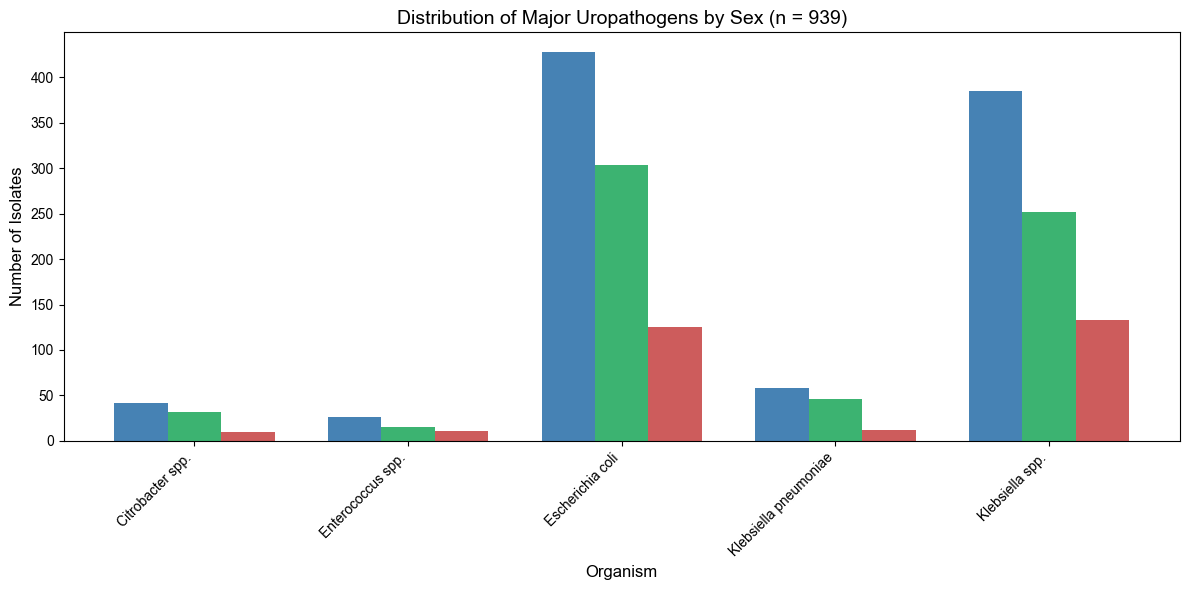

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

# Load Arial font (adjust path to ARIAL.TTF if needed)
arial_font = FontProperties(fname='ARIAL.TTF')

# Extract counts from processed DataFrame
organisms = organism_counts_filtered_manual.index.tolist()
female_counts = organism_counts_filtered_manual['Female'].values
male_counts = organism_counts_filtered_manual['Male'].values
total_counts = organism_counts_filtered_manual['Total'].values

x = np.arange(len(organisms))
width = 0.25

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

# Bars: Total, Female, Male
ax.bar(x - width, total_counts, width, label='Total', color='steelblue')
ax.bar(x, female_counts, width, label='Female', color='mediumseagreen')
ax.bar(x + width, male_counts, width, label='Male', color='indianred')

# Labels and formatting
ax.set_xlabel('Organism', fontproperties=arial_font, fontsize=12)
ax.set_ylabel('Number of Isolates', fontproperties=arial_font, fontsize=12)
ax.set_title('Distribution of Major Uropathogens by Sex (n = 939)', fontproperties=arial_font, fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(organisms, rotation=45, ha='right', fontproperties=arial_font, fontsize=10)
#ax.legend(loc='upper left', prop=arial_font)
plt.yticks(fontproperties=arial_font, fontsize=10)

# Save as Dove-compliant figure
output_file = "MRRH2024_Figure1.jpg"
plt.tight_layout()
fig.savefig(output_file, format='jpg', dpi=300)
plt.show()
#dowload the Figure
#from google.colab import files
files.download(output_file)

In [64]:
# Define age bins and labels
bins = [0, 15, 26, 36, 46, 66, float('inf')]  # Define bin edges
labels = ['0-14', '15-25', '26-35', '36-45', '46-65', '>65']  # Define labels

# Assign Age Group to the DataFrame
urine_data['Age Group'] = pd.cut(urine_data['Age'], bins=bins, labels=labels, right=False)
# prompt: code to calculate organism_counts_by_age_group
organism_counts_by_age_group = urine_data.groupby(['Organism', 'Age Group'])['Organism'].count().unstack(fill_value=0)
organism_counts_by_age_group

<ipython-input-64-c8da0f40d5db>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  organism_counts_by_age_group = urine_data.groupby(['Organism', 'Age Group'])['Organism'].count().unstack(fill_value=0)


Age Group,0-14,15-25,26-35,36-45,46-65,>65
Organism,,,,,,
Citrobacter spp.,2,5,7,12,10,6
Enterococcus spp.,0,2,7,9,5,3
Escherichia coli,24,68,84,92,99,61
Klebsiella pneumoniae,5,13,10,10,19,1
Klebsiella spp.,13,64,120,69,82,37


In [65]:
#

In [66]:
from scipy.stats import chi2_contingency

# Prepare the contingency table for Organism and Age Group
# organism_counts_by_age_group already has Organisms as index and Age Groups as columns
contingency_table_age = organism_counts_by_age_group.values

# Perform the Chi-square test
chi2_stat_age, p_value_age, dof_age, expected_age = chi2_contingency(contingency_table_age)

# Print test results for age group analysis
print("\nChi-square Test of Independence (Organism vs. Age Group):")
print(f"Chi-square statistic: {chi2_stat_age:.3f}")
print(f"Degrees of freedom: {dof_age}")
print(f"P-value: {p_value_age:.4f}")

# Optional: show expected frequencies
expected_age_df = pd.DataFrame(expected_age, columns=organism_counts_by_age_group.columns)
expected_age_df.index = organism_counts_by_age_group.index
print("\nExpected frequencies (Organism vs. Age Group):")
print(expected_age_df)


Chi-square Test of Independence (Organism vs. Age Group):
Chi-square statistic: 39.834
Degrees of freedom: 20
P-value: 0.0052

Expected frequencies (Organism vs. Age Group):
Age Group                   0-14      15-25       26-35      36-45      46-65  \
Organism                                                                        
Citrobacter spp.        1.968051   6.798722   10.198083   8.587859   9.616613   
Enterococcus spp.       1.218317   4.208733    6.313099   5.316294   5.953142   
Escherichia coli       20.055378  69.282215  103.923323  87.514377  97.997870   
Klebsiella pneumoniae   2.717785   9.388711   14.083067  11.859425  13.280085   
Klebsiella spp.        18.040469  62.321619   93.482428  78.722045  88.152290   

Age Group                    >65  
Organism                          
Citrobacter spp.        4.830671  
Enterococcus spp.       2.990415  
Escherichia coli       49.226837  
Klebsiella pneumoniae   6.670927  
Klebsiella spp.        44.281150  


In [67]:
#check unique sex
print(urine_data['Sex'].unique())

['F' 'M']


In [68]:
import pandas as pd
from scipy.stats import chi2_contingency

# Step 1: Build 3-way contingency: Organism × Age Group × Sex
contingency_3d = urine_data.groupby(['Organism', 'Age Group', 'Sex']).size().unstack(fill_value=0)

# Step 2: Flatten into 2D table: rows = "Organism | Age Group", columns = ['Female', 'Male']
flattened = contingency_3d.reset_index()
flattened['Group'] = flattened['Organism'] + " | " + flattened['Age Group'].astype(str)
chi_table = flattened[['Group', 'F', 'M']].set_index('Group')

# Step 3: Remove any rows with a zero in either Female or Male count
chi_table_filtered = chi_table[(chi_table != 0).all(axis=1)]

# Step 4: Perform Chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(chi_table_filtered.values)

# Step 5: Format expected frequencies
expected_df = pd.DataFrame(expected, index=chi_table_filtered.index, columns=chi_table_filtered.columns)

# Display results
print("Chi-square Test of Independence (Organism + Age Group vs. Sex):")
print(f"Chi-square statistic: {chi2_stat:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value:.4f}")
print("\nExpected Frequencies:")
print(expected_df)


Chi-square Test of Independence (Organism + Age Group vs. Sex):
Chi-square statistic: 74.886
Degrees of freedom: 26
P-value: 0.0000

Expected Frequencies:
Sex                                    F          M
Group                                              
Citrobacter spp. | 0-14         1.373650   0.626350
Citrobacter spp. | 15-25        3.434125   1.565875
Citrobacter spp. | 26-35        4.807775   2.192225
Citrobacter spp. | 46-65        6.868251   3.131749
Citrobacter spp. | >65          4.120950   1.879050
Enterococcus spp. | 15-25       1.373650   0.626350
Enterococcus spp. | 26-35       4.807775   2.192225
Enterococcus spp. | 36-45       6.181425   2.818575
Enterococcus spp. | 46-65       3.434125   1.565875
Enterococcus spp. | >65         2.060475   0.939525
Escherichia coli | 0-14        16.483801   7.516199
Escherichia coli | 15-25       46.704104  21.295896
Escherichia coli | 26-35       57.693305  26.306695
Escherichia coli | 36-45       63.187905  28.812095
Escherichia c

<ipython-input-68-a96bf6c3947d>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  contingency_3d = urine_data.groupby(['Organism', 'Age Group', 'Sex']).size().unstack(fill_value=0)


In [69]:
from scipy.stats import chi2_contingency
import pandas as pd

# STEP 1: Prepare the contingency table
contingency_table_age = organism_counts_by_age_group.values

# STEP 2: Perform the Chi-square test
chi2_stat_age, p_value_age, dof_age, expected_age = chi2_contingency(contingency_table_age)

# STEP 3: Print Chi-square test results
print("\nChi-square Test of Independence (Organism vs. Age Group):")
print(f"Chi-square statistic: {chi2_stat_age:.3f}")
print(f"Degrees of freedom: {dof_age}")
print(f"P-value: {p_value_age:.4f}")

# STEP 4: Show expected frequencies
expected_age_df = pd.DataFrame(expected_age, columns=organism_counts_by_age_group.columns)
expected_age_df.index = organism_counts_by_age_group.index
print("\nExpected frequencies (Organism vs. Age Group):")
print(expected_age_df)

# STEP 5: Calculate chi-square contributions for each cell
contributions = (contingency_table_age - expected_age) ** 2 / expected_age
contribution_df = pd.DataFrame(contributions, index=organism_counts_by_age_group.index, columns=organism_counts_by_age_group.columns)

# STEP 6: Sum contributions by age group (columns)
age_group_contributions = contribution_df.sum(axis=0)
most_significant_age_group = age_group_contributions.idxmax()
highest_contribution = age_group_contributions.max()

# STEP 7: Print contribution results
print("\nChi-square contribution by age group:")
print(age_group_contributions)

print(f"\nMost statistically significant age group: {most_significant_age_group}")
print(f"Contribution to Chi-square: {highest_contribution:.4f}")



Chi-square Test of Independence (Organism vs. Age Group):
Chi-square statistic: 39.834
Degrees of freedom: 20
P-value: 0.0052

Expected frequencies (Organism vs. Age Group):
Age Group                   0-14      15-25       26-35      36-45      46-65  \
Organism                                                                        
Citrobacter spp.        1.968051   6.798722   10.198083   8.587859   9.616613   
Enterococcus spp.       1.218317   4.208733    6.313099   5.316294   5.953142   
Escherichia coli       20.055378  69.282215  103.923323  87.514377  97.997870   
Klebsiella pneumoniae   2.717785   9.388711   14.083067  11.859425  13.280085   
Klebsiella spp.        18.040469  62.321619   93.482428  78.722045  88.152290   

Age Group                    >65  
Organism                          
Citrobacter spp.        4.830671  
Enterococcus spp.       2.990415  
Escherichia coli       49.226837  
Klebsiella pneumoniae   6.670927  
Klebsiella spp.        44.281150  

Chi-square 

In [70]:
from scipy.stats import chi2_contingency
import pandas as pd

# Sample input: replace with your actual organism_counts_by_age_group DataFrame
# organism_counts_by_age_group = pd.DataFrame({...}, index=[...])

# Store results
results = []

# Loop through each organism to test its age group distribution
for organism, row in organism_counts_by_age_group.iterrows():
    # Create a 2D array: [observed counts]
    observed = [row.values]

    # Create expected frequencies based on age group totals
    age_group_totals = organism_counts_by_age_group.sum()
    organism_total = row.sum()
    grand_total = organism_counts_by_age_group.values.sum()
    expected = [(age_group_totals / grand_total) * organism_total]

    # Chi-square test
    chi2, p, dof, _ = chi2_contingency([observed[0], expected[0]], correction=False)

    results.append({
        'Organism': organism,
        'Chi-square': round(chi2, 3),
        'df': dof,
        'P-value': round(p, 4)
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print("\nChi-square Test of Independence (Organism vs. Age Group):")
print(results_df.to_string(index=False))



Chi-square Test of Independence (Organism vs. Age Group):
             Organism  Chi-square  df  P-value
     Citrobacter spp.       1.568   5   0.9050
    Enterococcus spp.       3.070   5   0.6891
     Escherichia coli       3.852   5   0.5709
Klebsiella pneumoniae       7.314   5   0.1983
      Klebsiella spp.       5.649   5   0.3419


In [71]:
#list organisms
print(urine_data['Organism'].unique())

['Klebsiella spp.' 'Escherichia coli' 'Klebsiella pneumoniae'
 'Enterococcus spp.' 'Citrobacter spp.']


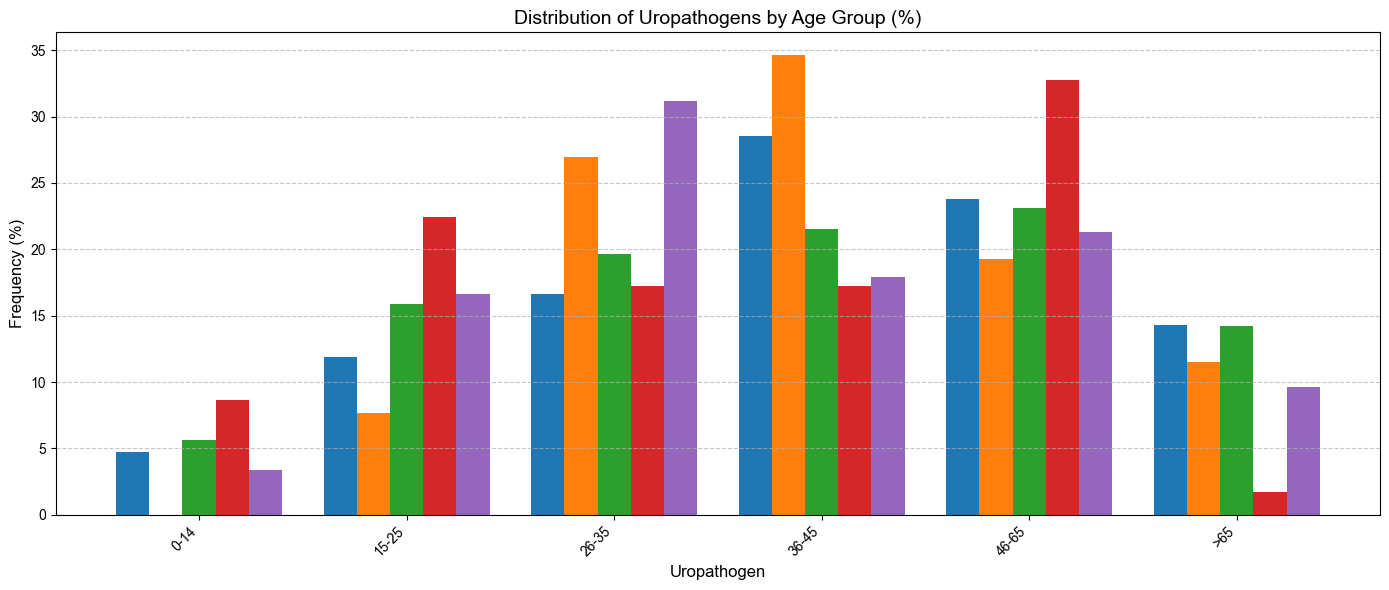

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

# Load Arial font (adjust path if needed)
arial_font = FontProperties(fname='ARIAL.TTF')

# Ensure "Other Organisms" is last
if "Other Organisms" in organism_counts_by_age_group.index:
    organism_counts_by_age_group = organism_counts_by_age_group.loc[
        [org for org in organism_counts_by_age_group.index if org != "Other Organisms"] + ["Other Organisms"]
    ]

# Transpose for plotting
organism_counts_by_age_group = organism_counts_by_age_group.T

# Calculate percentages per organism (i.e., column-wise)
totals = organism_counts_by_age_group.sum(axis=0)
percentages = organism_counts_by_age_group.divide(totals, axis=1) * 100

# Dynamic bar width based on age groups
num_organisms = len(organism_counts_by_age_group.index)
num_age_groups = len(organism_counts_by_age_group.columns)
bar_width = 0.8 / num_age_groups
x_pos = np.arange(len(organism_counts_by_age_group.index))

# Plot setup
fig, ax = plt.subplots(figsize=(14, 6))

# Create bars
for i, age_group in enumerate(organism_counts_by_age_group.columns):
    percents = percentages[age_group]
    ax.bar(
        x_pos + i * bar_width,
        percents,
        width=bar_width,
        label=age_group
    )

# Labels and formatting (Arial)
ax.set_xlabel('Uropathogen', fontproperties=arial_font, fontsize=12)
ax.set_ylabel('Frequency (%)', fontproperties=arial_font, fontsize=12)
ax.set_title('Distribution of Uropathogens by Age Group (%)', fontproperties=arial_font, fontsize=14)

ax.set_xticks(x_pos + bar_width * (num_age_groups / 2) - bar_width / 2)
ax.set_xticklabels(organism_counts_by_age_group.index, rotation=45, ha='right', fontproperties=arial_font, fontsize=10)
plt.yticks(fontproperties=arial_font, fontsize=10)
#ax.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left', prop=arial_font)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Save and show
plt.tight_layout()
plt.savefig("MRRH2024_Figure2.jpg", format='jpg', dpi=300)
plt.show()
#dowload the Figure
from google.colab import files
files.download("MRRH2024_Figure2.jpg")


In [73]:
import pandas as pd

# ... (your previous code to load, process, and encode urine_data) ...

# Select columns containing antibiotic data (encoded columns)
antibiotic_columns = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]  # Corrected line

# Create a dictionary to store the counts
antibiotic_counts = {}

# Iterate through antibiotic columns and count I, R, S
for column in antibiotic_columns:
    antibiotic_name = column[:-2]  # Extract antibiotic name from column name

    # Get the category (I, R, or S) from the column name
    category = column[-1]

    # Store the count in the dictionary, creating a new entry for the antibiotic if needed
    if antibiotic_name not in antibiotic_counts:
        antibiotic_counts[antibiotic_name] = {'I': 0, 'R': 0, 'S': 0}  # Initialize counts to 0

    antibiotic_counts[antibiotic_name][category] = urine_data[column].sum()
# Convert the dictionary to a DataFrame for better display
antibiotic_counts_df = pd.DataFrame(antibiotic_counts).T
antibiotic_counts_df.index.name = 'Antibiotic'
# Display the results
print(antibiotic_counts_df)

print(len(urine_data))

                                I      R      S
Antibiotic                                     
Amoxicillin/Clavulanic Acid   8.0  316.0  297.0
Ampicillin                    4.0  270.0   26.0
Azlocillin                    0.0    1.0    0.0
Aztreonam                     2.0   27.0   16.0
Cefaclor                      1.0   14.0   10.0
Cefazolin                     3.0   77.0  138.0
Ceftazidime                   0.0   30.0  129.0
Cefotaxime                    1.0  125.0  353.0
Ceftriaxone                   9.0  276.0  335.0
Ciprofloxacin                19.0  157.0  450.0
Clindamycin                   0.0    7.0   12.0
Chloramphenicol               8.0  318.0  285.0
Erythromycin                  1.0   15.0    6.0
Gentamicin                    6.0  108.0  511.0
Imipenem                     10.0   50.0  525.0
Meropenem                     2.0    2.0   42.0
Moxifloxacin                  1.0    3.0    4.0
Nitrofurantoin               27.0   50.0  272.0
Ofloxacin                     0.0    1.0

In [74]:
#Let us remove the antibiotics that have only zeros for I, R and S from our encoded columns


In [75]:
import pandas as pd

# STEP 1: Load your urine_data DataFrame here
# Example:
# urine_data = pd.read_csv('your_file.csv')

# STEP 2: Select antibiotic AST result columns (e.g., 'CIP_S', 'CIP_R')
antibiotic_columns = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]

# STEP 3: Count S, I, R values for each antibiotic
antibiotic_counts = {}

for column in antibiotic_columns:
    antibiotic_name = column[:-2]  # e.g., 'CIP' from 'CIP_R'
    category = column[-1]          # 'R', 'I', or 'S'

    if antibiotic_name not in antibiotic_counts:
        antibiotic_counts[antibiotic_name] = {'S': 0, 'I': 0, 'R': 0}

    antibiotic_counts[antibiotic_name][category] = urine_data[column].sum()

# STEP 4: Convert to DataFrame for display
antibiotic_counts_df = pd.DataFrame(antibiotic_counts).T
antibiotic_counts_df.index.name = 'Antibiotic'
print("Antibiotic Resistance Profile:")
print(antibiotic_counts_df)

# STEP 5: Compute number of isolates resistant to at least one antibiotic
# Create a mask where any '_I' or '_R' column == 1 → considered resistant
resistance_cols = [col for col in antibiotic_columns if col.endswith('_I') or col.endswith('_R')]
resistance_flags = urine_data[resistance_cols].sum(axis=1) > 0
urine_data['Resistant_to_Any'] = resistance_flags


# STEP 6: Total resistant isolates
total_resistant = urine_data['Resistant_to_Any'].sum()
print(f"\nTotal isolates resistant to at least one antibiotic: {total_resistant} / {len(urine_data)}")

# STEP 7: Group by organism
resistant_by_organism = urine_data.groupby('Organism')['Resistant_to_Any'].agg(
    Resistant_Count='sum',
    Total_Isolates='count'
)
resistant_by_organism['Proportion (%)'] = (resistant_by_organism['Resistant_Count'] / resistant_by_organism['Total_Isolates']) * 100
resistant_by_organism = resistant_by_organism.sort_values(by='Resistant_Count', ascending=False).round(1)

print("\nResistant Isolates by Organism:")
print(resistant_by_organism)


Antibiotic Resistance Profile:
                                 S     I      R
Antibiotic                                     
Amoxicillin/Clavulanic Acid  297.0   8.0  316.0
Ampicillin                    26.0   4.0  270.0
Azlocillin                     0.0   0.0    1.0
Aztreonam                     16.0   2.0   27.0
Cefaclor                      10.0   1.0   14.0
Cefazolin                    138.0   3.0   77.0
Ceftazidime                  129.0   0.0   30.0
Cefotaxime                   353.0   1.0  125.0
Ceftriaxone                  335.0   9.0  276.0
Ciprofloxacin                450.0  19.0  157.0
Clindamycin                   12.0   0.0    7.0
Chloramphenicol              285.0   8.0  318.0
Erythromycin                   6.0   1.0   15.0
Gentamicin                   511.0   6.0  108.0
Imipenem                     525.0  10.0   50.0
Meropenem                     42.0   2.0    2.0
Moxifloxacin                   4.0   1.0    3.0
Nitrofurantoin               272.0  27.0   50.0
Ofloxacin

In [76]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

import pandas as pd
from IPython.display import display

# Select encoded antibiotic susceptibility columns
antibiotic_columns = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]

# Initialize dictionary for counting
antibiotic_counts = {}

for column in antibiotic_columns:
    antibiotic_name = column[:-2]  # Strip suffix (_R/_S/_I)
    category = column[-1]         # Get suffix (R/S/I)

    if antibiotic_name not in antibiotic_counts:
        antibiotic_counts[antibiotic_name] = {'Resistant': 0, 'Sensitive': 0, 'Total Culture': 0}

    if category in ('I', 'R'):
        antibiotic_counts[antibiotic_name]['Resistant'] += urine_data[column].sum()
    elif category == 'S':
        antibiotic_counts[antibiotic_name]['Sensitive'] += urine_data[column].sum()

    # Update total
    antibiotic_counts[antibiotic_name]['Total Culture'] = (
        antibiotic_counts[antibiotic_name]['Resistant'] +
        antibiotic_counts[antibiotic_name]['Sensitive']
    )

# Construct table
antimicrobial_agents = list(antibiotic_counts.keys())
table_data = {
    'Antimicrobial\nAgents': antimicrobial_agents,
    'No. of Cultures Tested': [],
    'Resistant No (%)': []
}

for agent in antimicrobial_agents:
    total = antibiotic_counts[agent]['Total Culture']
    r = antibiotic_counts[agent]['Resistant']

    table_data['No. of Cultures Tested'].append(total)
    table_data['Resistant No (%)'].append(f"{r} ({r / total * 100:.1f}%)" if total else '0 (0.0%)')

# Create and sort DataFrame
susceptibility_table = pd.DataFrame(table_data)
susceptibility_table = susceptibility_table.sort_values(by='Antimicrobial\nAgents')

# Display using Colab’s interactive table
display(data_table.DataTable(susceptibility_table))


,Antimicrobial\nAgents,No. of Cultures Tested,Resistant No (%)
0,Amoxicillin/Clavulanic Acid,621.0,324 (52.2%)
1,Ampicillin,300.0,274 (91.3%)
2,Azlocillin,1.0,1 (100.0%)
3,Aztreonam,45.0,29.0 (64.4%)
4,Cefaclor,25.0,15 (60.0%)
5,Cefazolin,218.0,80 (36.7%)
7,Cefotaxime,479.0,126.0 (26.3%)
23,Cefoxitin 30 mg,49.0,19 (38.8%)
6,Ceftazidime,159.0,30.0 (18.9%)
8,Ceftriaxone,620.0,285.0 (46.0%)


In [77]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

import pandas as pd
from IPython.display import display

# Select encoded antibiotic susceptibility columns
antibiotic_columns = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]

# Initialize dictionary for counting
antibiotic_counts = {}

for column in antibiotic_columns:
    antibiotic_name = column[:-2].replace('_', ' ').title()  # Clean up name
    category = column[-1]

    if antibiotic_name not in antibiotic_counts:
        antibiotic_counts[antibiotic_name] = {'Resistant': 0, 'Sensitive': 0, 'Total Culture': 0}

    if category in ('I', 'R'):
        antibiotic_counts[antibiotic_name]['Resistant'] += urine_data[column].sum()
    elif category == 'S':
        antibiotic_counts[antibiotic_name]['Sensitive'] += urine_data[column].sum()

    # Update total
    antibiotic_counts[antibiotic_name]['Total Culture'] = (
        antibiotic_counts[antibiotic_name]['Resistant'] + antibiotic_counts[antibiotic_name]['Sensitive']
    )

# Prepare table
table_rows = []
other_resistant = other_total = 0

for agent, stats in antibiotic_counts.items():
    total = stats['Total Culture']
    r = stats['Resistant']
    if total >= 25:
        table_rows.append({
            'Antimicrobial Agents': agent,
            'No. of Cultures Tested': total,
            'Resistant No (%)': f"{r} ({r / total * 100:.1f}%)"
        })
    else:
        other_resistant += r
        other_total += total

# Add grouped row for sparse agents
if other_total > 0:
    table_rows.append({
        'Antimicrobial Agents': 'Other agents',
        'No. of Cultures Tested': other_total,
        'Resistant No (%)': f"{other_resistant} ({other_resistant / other_total * 100:.1f}%)"
    })

# Create and display table
susceptibility_table = pd.DataFrame(table_rows)
susceptibility_table = susceptibility_table.sort_values(by='Antimicrobial Agents')
display(data_table.DataTable(susceptibility_table))


,Antimicrobial Agents,No. of Cultures Tested,Resistant No (%)
0,Amoxicillin/Clavulanic Acid,621.0,324 (52.2%)
1,Ampicillin,300.0,274 (91.3%)
2,Aztreonam,45.0,29.0 (64.4%)
3,Cefaclor,25.0,15 (60.0%)
4,Cefazolin,218.0,80 (36.7%)
6,Cefotaxime,479.0,126.0 (26.3%)
15,Cefoxitin 30 Mg,49.0,19 (38.8%)
5,Ceftazidime,159.0,30.0 (18.9%)
7,Ceftriaxone,620.0,285.0 (46.0%)
9,Chloramphenicol,611.0,326 (53.4%)


In [78]:
# Count how many agents were grouped under 'Other agents'
other_agents_count = sum(1 for agent, stats in antibiotic_counts.items() if stats['Total Culture'] < 15)
print(f"Number of antimicrobial agents grouped under 'Other agents': {other_agents_count}")
#print list of grouped agents
grouped_agents = [agent for agent, stats in antibiotic_counts.items() if stats['Total Culture'] < 15]
print(f"List of grouped agents: {grouped_agents}")

Number of antimicrobial agents grouped under 'Other agents': 5
List of grouped agents: ['Azlocillin', 'Moxifloxacin', 'Ofloxacin', 'Oxacillin', 'Vancomycin']


In [79]:
import pandas as pd
from google.colab import data_table

data_table.enable_dataframe_formatter()

# ... (your existing code to load and preprocess urine_data) ...

# Get unique organisms and antimicrobial agents
unique_organisms = urine_data['Organism'].unique()
antibiotic_columns = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]
antimicrobial_agents = list(set([col[:-2] for col in antibiotic_columns]))

# Create a dictionary to store the table data (organisms as rows, antibiotics as columns)
table_data = {}

# Loop through organisms and antimicrobial agents to populate the table
for organism in unique_organisms:
    for agent in antimicrobial_agents:
        # Create keys for 'T' and 'RNo (%)' for each organism-antibiotic pair
        total_key = organism + ' T_' + agent  # Unique key for Total
        rno_key = organism + ' RNo (%)_' + agent  # Unique key for RNo (%)

        try:
            # Calculate total tested and resistant count
            total_tested = urine_data.loc[urine_data['Organism'] == organism, [agent + '_I', agent + '_R', agent + '_S']].sum().sum()
            #resistant_count = filtered_data.loc[filtered_data['Organism'] == organism, [agent + '_I', agent + '_R']].sum().sum()
            resistant_count = urine_data.loc[urine_data['Organism'] == organism, [agent + '_I', agent + '_R',]].sum().sum()

            # Store values in the table_data dictionary
            table_data[total_key] = total_tested
            table_data[rno_key] = f"{resistant_count} ({resistant_count / total_tested * 100:.1f})" if total_tested else 'ND'

        except KeyError:
            # Handle cases where the agent is not found for the current organism
            table_data[total_key] = 'ND'
            table_data[rno_key] = 'ND'

# Create the DataFrame
susceptibility_table = pd.DataFrame([table_data]).T.rename(columns={0: 'Value'})

# Split the index values safely with conditional checks
susceptibility_table['Organism'] = susceptibility_table.index.map(lambda x: x.split(' T_')[0] if ' T_' in x else x.split(' RNo (%)_')[0])
susceptibility_table['Type'] = susceptibility_table.index.map(lambda x: 'T' if ' T_' in x else 'RNo (%)')
susceptibility_table['Antibiotic'] = susceptibility_table.index.map(lambda x: x.split(' T_')[1] if ' T_' in x else x.split(' RNo (%)_')[1])

# Reshape the DataFrame to have organisms as rows
susceptibility_table = susceptibility_table.set_index(['Organism', 'Type', 'Antibiotic'])['Value'].unstack('Antibiotic')
#remove all antibiotics that have only ND values throughout
susceptibility_table = susceptibility_table.loc[:, (susceptibility_table != 'ND').any(axis=0)]
#sort ascending
susceptibility_table = susceptibility_table.sort_values(by='Organism', ascending=True)

# Display the table using data_table formatter
display(susceptibility_table)

Antibiotic                    Amoxicillin/Clavulanic Acid  Ampicillin  \
Organism              Type                                              
Citrobacter spp.      RNo (%)                   11 (78.6)   3 (100.0)   
                      T                                14           3   
Enterococcus spp.     RNo (%)                    2 (13.3)    5 (45.5)   
                      T                                15          11   
Escherichia coli      RNo (%)                  136 (55.1)  174 (91.6)   
                      T                               247         190   
Klebsiella pneumoniae RNo (%)                   30 (81.1)   27 (96.4)   
                      T                                37          28   
Klebsiella spp.       RNo (%)                  145 (47.1)   65 (95.6)   
                      T                               308          68   

Antibiotic                       Aztreonam  Cefaclor  Cefazolin   Cefotaxime  \
Organism              Type                                                     
Citrobacter spp.      RNo (%)   3.0 (75.0)        ND         ND  3.0 (100.0)   
                      T                4.0         0          0          3.0   
Enterococcus spp.     RNo (%)           ND        ND   1 (33.3)           ND   
                      T                0.0         0          3          0.0   
Escherichia coli      RNo (%)  21.0 (63.6)  7 (70.0)  34 (27.0)  42.0 (29.6)   
                      T               33.0        10        126        142.0   
Klebsiella pneumoniae RNo (%)   2.0 (50.0)   0 (0.0)  10 (40.0)   5.0 (50.0)   
                      T                4.0         1         25         10.0   
Klebsiella spp.       RNo (%)   3.0 (75.0)  8 (57.1)  35 (54.7)  76.0 (23.5)   
                      T                4.0        14         64        324.0   

Antibiotic                    Cefoxitin 30 mg   Ceftriaxone Chloramphenicol  \
Organism              Type                                                    
Citrobacter spp.      RNo (%)       1 (100.0)   15.0 (60.0)        4 (57.1)   
                      T                     1          25.0               7   
Enterococcus spp.     RNo (%)              ND            ND        7 (70.0)   
                      T                     0           0.0              10   
Escherichia coli      RNo (%)       13 (43.3)  114.0 (48.3)       88 (40.6)   
                      T                    30         236.0             217   
Klebsiella pneumoniae RNo (%)        3 (33.3)   15.0 (68.2)       13 (36.1)   
                      T                     9          22.0              36   
Klebsiella spp.       RNo (%)        2 (22.2)  141.0 (41.8)      214 (62.8)   
                      T                     9         337.0             341   

Antibiotic                    Ciprofloxacin Clindamycin Erythromycin  \
Organism              Type                                             
Citrobacter spp.      RNo (%)   13.0 (72.2)          ND           ND   
                      T                18.0         0.0          0.0   
Enterococcus spp.     RNo (%)            ND  7.0 (36.8)  16.0 (72.7)   
                      T                 0.0        19.0         22.0   
Escherichia coli      RNo (%)   95.0 (38.2)          ND           ND   
                      T               249.0         0.0          0.0   
Klebsiella pneumoniae RNo (%)   15.0 (46.9)          ND           ND   
                      T                32.0         0.0          0.0   
Klebsiella spp.       RNo (%)   53.0 (16.2)          ND           ND   
                      T               327.0         0.0          0.0   

Antibiotic                    Gentamicin     Imipenem Meropenem Moxifloxacin  \
Organism              Type                                                     
Citrobacter spp.      RNo (%)   5 (55.6)   7.0 (25.9)        ND           ND   
                      T                9         27.0         0            0   
Enterococcus spp.     RNo (%

In [80]:
import pandas as pd
from google.colab import data_table

data_table.enable_dataframe_formatter()

# ... (your existing code to load and preprocess urine_data and create table_data dictionary) ...

# Create the DataFrame from the dictionary
susceptibility_table = pd.DataFrame([table_data]).T.rename(columns={0: 'Value'})

# Split the index values safely with conditional checks
susceptibility_table['Organism'] = susceptibility_table.index.map(lambda x: x.split(' T_')[0] if ' T_' in x else x.split(' RNo (%)_')[0])
susceptibility_table['Type'] = susceptibility_table.index.map(lambda x: 'T' if ' T_' in x else 'RNo (%)')
susceptibility_table['Antibiotic'] = susceptibility_table.index.map(lambda x: x.split(' T_')[1] if ' T_' in x else x.split(' RNo (%)_')[1])

# Reshape the DataFrame to have Antibiotic and Type as a multi-level index (rows)
# and Organism as columns.
susceptibility_table = susceptibility_table.set_index(['Antibiotic', 'Type', 'Organism'])['Value'].unstack('Organism')

# Remove organism columns that have only ND values throughout
susceptibility_table = susceptibility_table.loc[:, (susceptibility_table != 'ND').any(axis=0)]

# Sort the multi-level index first by Antibiotic, then by Type (putting 'T' before 'RNo (%)')
susceptibility_table = susceptibility_table.sort_index(level=['Antibiotic', 'Type'], ascending=[True, True])

# Display the table using data_table formatter
display(data_table.DataTable(susceptibility_table))

In [81]:
import pandas as pd
from google.colab import data_table

# Enable the Colab interactive table
data_table.enable_dataframe_formatter()

# Step 1: Build base DataFrame from table_data
df = pd.DataFrame([table_data]).T.rename(columns={0: 'Value'})
df['Organism'] = df.index.map(lambda x: x.split(' T_')[0] if ' T_' in x else x.split(' RNo (%)_')[0])
df['Type'] = df.index.map(lambda x: 'T' if ' T_' in x else 'RNo (%)')
df['Antibiotic'] = df.index.map(lambda x: x.split(' T_')[1] if ' T_' in x else x.split(' RNo (%)_')[1])

# Step 2: Get total counts per antibiotic
total_counts = df[df['Type'] == 'T'].groupby('Antibiotic')['Value'].apply(
    lambda x: sum(pd.to_numeric(x, errors='coerce').fillna(0))
)

# Step 3: Group those < threshold as 'Other agents'
threshold = 25
keep_agents = total_counts[total_counts >= threshold].index.tolist()
df['Grouped_Agent'] = df['Antibiotic'].apply(lambda x: x if x in keep_agents else 'Other agents')
df['Antibiotic'] = df['Grouped_Agent']
df.drop(columns='Grouped_Agent', inplace=True)

# Step 4: Separate Total and Resistance data
df_T = df[df['Type'] == 'T'].copy()
df_T['Value'] = pd.to_numeric(df_T['Value'], errors='coerce').fillna(0)
df_T = df_T.groupby(['Antibiotic', 'Organism'])['Value'].sum().unstack(fill_value=0)

df_R = df[df['Type'] == 'RNo (%)'].copy()
df_R['Resistant'] = df_R['Value'].apply(lambda v: float(str(v).split()[0]) if v != 'ND' else 0)
df_R = df_R.groupby(['Antibiotic', 'Organism'])['Resistant'].sum().unstack(fill_value=0)

# Step 5: Merge and compute resistance %
result = {}
for agent in df_T.index:
    row = {}
    for org in df_T.columns:
        total = df_T.loc[agent, org]
        resistant = df_R.loc[agent, org]
        row[org] = f"{int(resistant)} ({(resistant/total*100):.1f}%)" if total > 0 else 'ND'
    result[agent] = row

# Step 6: Display as styled table
final_table = pd.DataFrame(result).T
display(data_table.DataTable(final_table))


,Citrobacter spp.,Enterococcus spp.,Escherichia coli,Klebsiella pneumoniae,Klebsiella spp.
Amoxicillin/Clavulanic Acid,11 (78.6%),2 (13.3%),136 (55.1%),30 (81.1%),145 (47.1%)
Ampicillin,3 (100.0%),5 (45.5%),174 (91.6%),27 (96.4%),65 (95.6%)
Aztreonam,3 (75.0%),ND,21 (63.6%),2 (50.0%),3 (75.0%)
Cefaclor,ND,ND,7 (70.0%),0 (0.0%),8 (57.1%)
Cefazolin,ND,1 (33.3%),34 (27.0%),10 (40.0%),35 (54.7%)
Cefotaxime,3 (100.0%),ND,42 (29.6%),5 (50.0%),76 (23.5%)
Cefoxitin 30 mg,1 (100.0%),ND,13 (43.3%),3 (33.3%),2 (22.2%)
Ceftriaxone,15 (60.0%),ND,114 (48.3%),15 (68.2%),141 (41.8%)
Chloramphenicol,4 (57.1%),7 (70.0%),88 (40.6%),13 (36.1%),214 (62.8%)
Ciprofloxacin,13 (72.2%),ND,95 (38.2%),15 (46.9%),53 (16.2%)


In [82]:
print("Grouped under 'Other agents':")
print(total_counts[total_counts < threshold])


Grouped under 'Other agents':
Antibiotic
Azlocillin       0.0
Ceftazidime      0.0
Clindamycin     19.0
Erythromycin    22.0
Moxifloxacin     8.0
Ofloxacin        0.0
Oxacillin        0.0
Penicillin       0.0
Vancomycin       5.0
Name: Value, dtype: float64


In [83]:
#display list of antibiotic that were removed
print(f"Number of antimicrobial agents grouped under 'Other agents': {other_agents_count}")
print(f"List of grouped agents: {grouped_agents}")


Number of antimicrobial agents grouped under 'Other agents': 5
List of grouped agents: ['Azlocillin', 'Moxifloxacin', 'Ofloxacin', 'Oxacillin', 'Vancomycin']


In [92]:
import pandas as pd
from IPython.display import display


df = pd.DataFrame([table_data]).T.rename(columns={0: 'Value'})

# Extract components
df['Organism'] = df.index.map(lambda x: x.split(' T_')[0] if ' T_' in x else x.split(' RNo (%)_')[0])
df['Type'] = df.index.map(lambda x: 'T' if ' T_' in x else 'RNo (%)')
df['Antibiotic'] = df.index.map(lambda x: x.split(' T_')[1] if ' T_' in x else x.split(' RNo (%)_')[1])

# Reshape: Antibiotic x Type x Organism
df = df.set_index(['Antibiotic', 'Type', 'Organism'])['Value'].unstack('Organism')

# Step 1: Get counts table
counts = df.loc[(slice(None), 'T'), :]
counts = counts.apply(pd.to_numeric, errors='coerce')

# Step 2: Flag organism-antibiotic pairs with <25 cultures
low_count_mask = counts < 25
low_count_organisms = low_count_mask.columns[low_count_mask.any()]
low_count_abx = low_count_mask[low_count_mask.any(axis=1)].index.get_level_values(0).unique()

# Step 3: Group these as 'Other organisms'
df_grouped = df.copy()
for abx in low_count_abx:
    for org in low_count_organisms:
        for t in ['T', 'RNo (%)']:
            try:
                val = df_grouped.loc[(abx, t), org]
                df_grouped.loc[(abx, t), 'Other organisms'] = val if pd.notnull(val) else df_grouped.loc[(abx, t), 'Other organisms']
                df_grouped.loc[(abx, t), org] = None  # remove original
            except KeyError:
                continue

# Drop all-NaN columns and show
df_grouped = df_grouped.dropna(axis=1, how='all').sort_index()
display(df_grouped)


<ipython-input-92-a135e6bb0dc2>:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11 (78.6)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_grouped.loc[(abx, t), 'Other organisms'] = val if pd.notnull(val) else df_grouped.loc[(abx, t), 'Other organisms']


Organism                            Citrobacter spp. Enterococcus spp.  \
Antibiotic                  Type                                         
Amoxicillin/Clavulanic Acid RNo (%)             None              None   
                            T                   None              None   
Ampicillin                  RNo (%)             None              None   
                            T                   None              None   
Azlocillin                  RNo (%)               ND                ND   
                            T                     ND                ND   
Aztreonam                   RNo (%)             None              None   
                            T                   None              None   
Cefaclor                    RNo (%)             None              None   
                            T                   None              None   
Cefazolin                   RNo (%)             None              None   
                            T                   None              None   
Cefotaxime                  RNo (%)             None              None   
                            T                   None              None   
Cefoxitin 30 mg             RNo (%)             None              None   
                            T                   None              None   
Ceftazidime                 RNo (%)               ND                ND   
                            T                     ND                ND   
Ceftriaxone                 RNo (%)             None              None   
                            T                   None              None   
Chloramphenicol             RNo (%)             None              None   
                            T                   None              None   
Ciprofloxacin               RNo (%)             None              None   
                            T                   None              None   
Clindamycin                 RNo (%)             None              None   
                            T                   None              None   
Erythromycin                RNo (%)             None              None   
                            T                   None              None   
Gentamicin                  RNo (%)             None              None   
                            T                   None              None   
Imipenem                    RNo (%)             None              None   
                            T                   None              None   
Meropenem                   RNo (%)             None              None   
                            T                   None              None   
Moxifloxacin                RNo (%)             None              None   
                            T                   None              None   
Nitrofurantoin              RNo (%)             None              None   
                            T                   None              None   
Ofloxacin                   RNo (%)               ND                ND   
                            T                     ND                ND   
Oxacillin                   RNo (%)               ND                ND   
                            T                     ND                ND   
Penicillin                  RNo (%)               ND                ND   
                            T                     ND                ND   
Sulfamethoxazole            RNo (%)             None              None   
                            T                   None              None   
Vancomycin                  RNo (%)             None              None   
                            T                   None              None   

Organism                            Escherichia coli Klebsiella pneumoniae  \
Antibiotic                  Type                                             
Amoxicillin/Clavulanic Acid RNo (%)             None                  None   
                            T                   None             

In [85]:
#display all antibiotic columns
print("Antibiotic Columns:")
for column in antibiotic_columns:
    print(column)

Antibiotic Columns:
Amoxicillin/Clavulanic Acid_I
Amoxicillin/Clavulanic Acid_R
Amoxicillin/Clavulanic Acid_S
Ampicillin_I
Ampicillin_R
Ampicillin_S
Azlocillin_R
Aztreonam_I
Aztreonam_R
Aztreonam_S
Cefaclor_I
Cefaclor_R
Cefaclor_S
Cefazolin_I
Cefazolin_R
Cefazolin_S
Ceftazidime_R
Ceftazidime_S
Cefotaxime_I
Cefotaxime_R
Cefotaxime_S
Ceftriaxone_I
Ceftriaxone_R
Ceftriaxone_S
Ciprofloxacin_I
Ciprofloxacin_R
Ciprofloxacin_S
Clindamycin_I
Clindamycin_R
Clindamycin_S
Chloramphenicol_I
Chloramphenicol_R
Chloramphenicol_S
Erythromycin_I
Erythromycin_R
Erythromycin_S
Gentamicin_I
Gentamicin_R
Gentamicin_S
Imipenem_I
Imipenem_R
Imipenem_S
Meropenem_I
Meropenem_R
Meropenem_S
Moxifloxacin_I
Moxifloxacin_R
Moxifloxacin_S
Nitrofurantoin_I
Nitrofurantoin_R
Nitrofurantoin_S
Ofloxacin_R
Ofloxacin_S
Oxacillin_R
Oxacillin_S
Vancomycin_I
Vancomycin_R
Vancomycin_S
Penicillin_R
Penicillin_S
Sulfamethoxazole_I
Sulfamethoxazole_R
Sulfamethoxazole_S
Cefoxitin 30 mg_I
Cefoxitin 30 mg_R
Cefoxitin 30 mg_S


In [86]:
!pip install pymannkendall


In [87]:
print(urine_data['Organism'].unique())


['Klebsiella spp.' 'Escherichia coli' 'Klebsiella pneumoniae'
 'Enterococcus spp.' 'Citrobacter spp.']


In [88]:
#unique specimen
print(urine_data['Specimen type'].unique())

['ur' 'urine' 'ue' 'uc']


<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


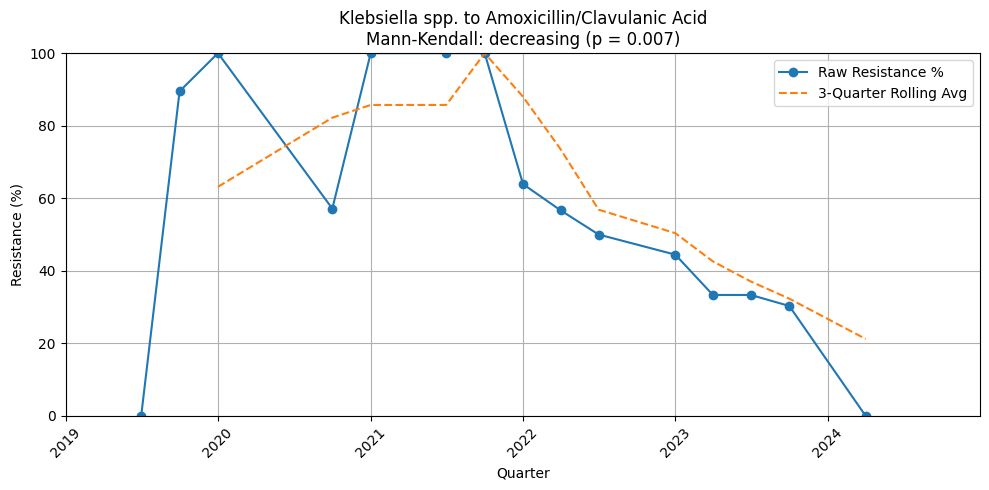

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


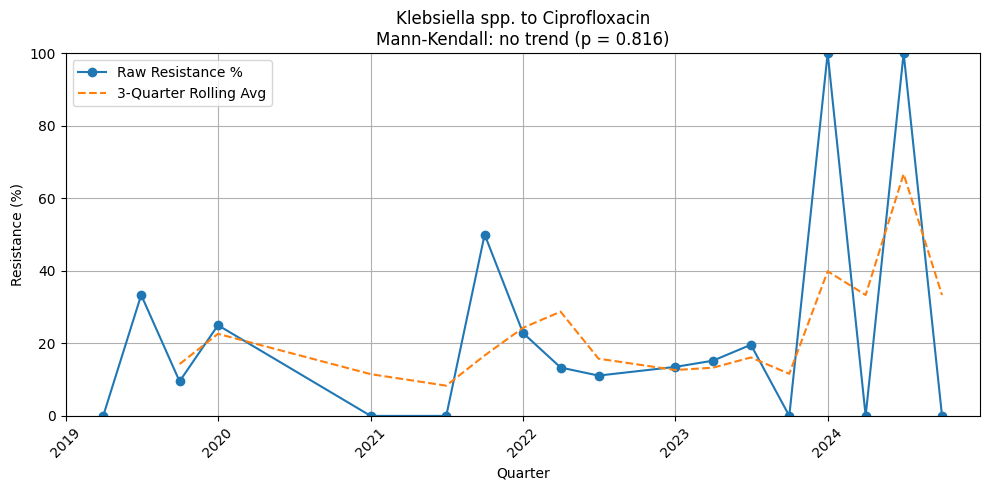

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


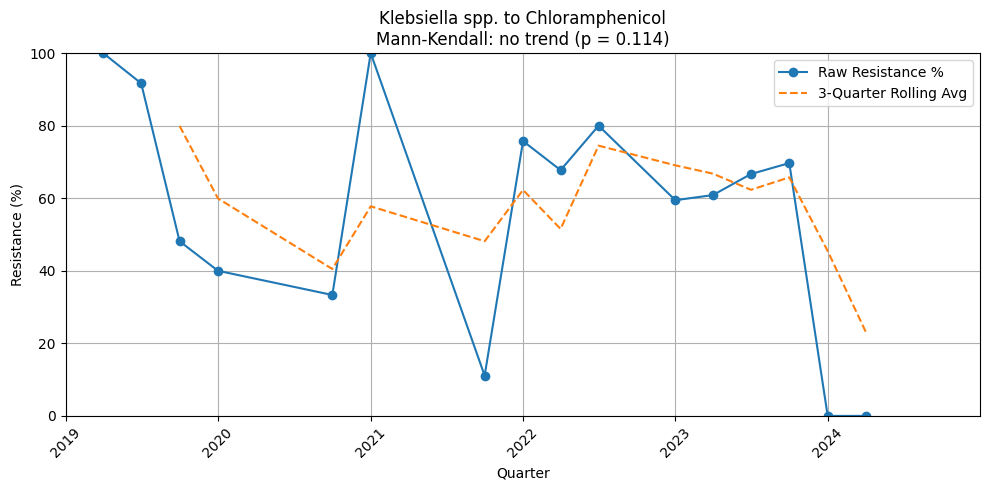

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


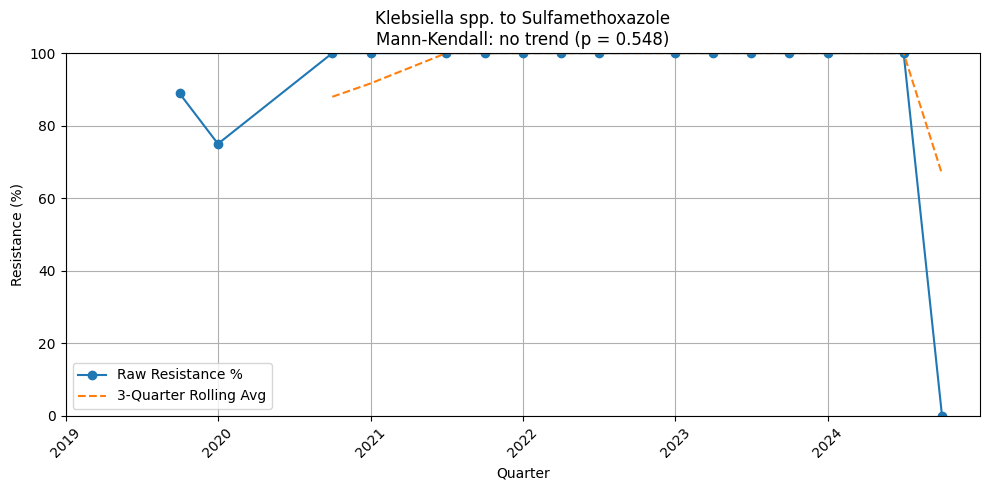

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


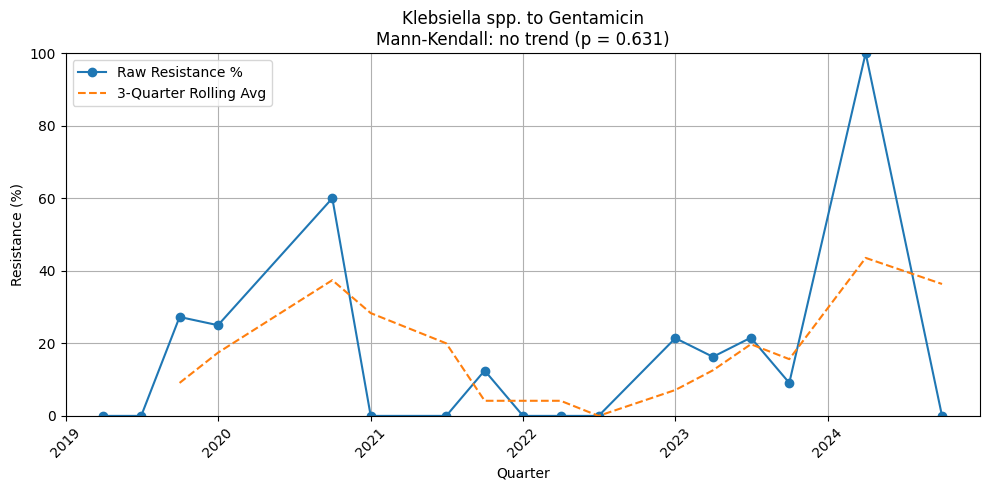

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


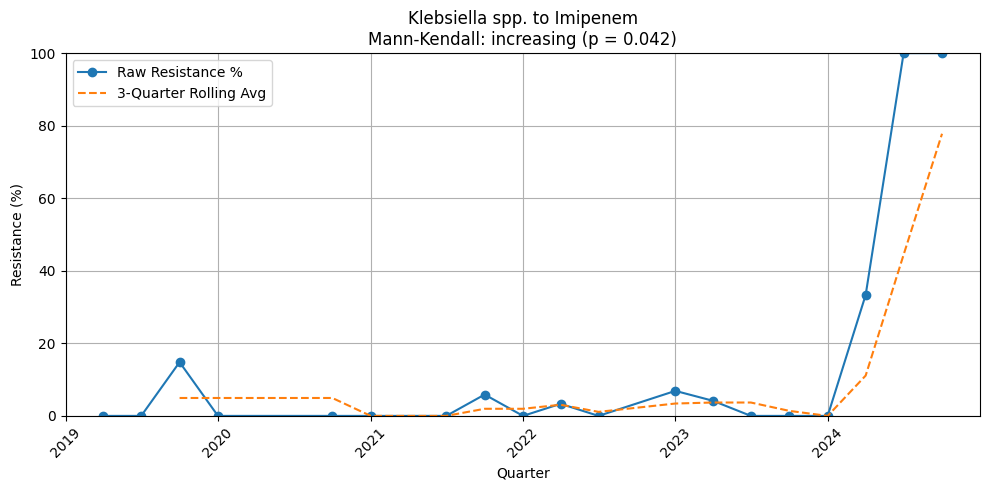

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


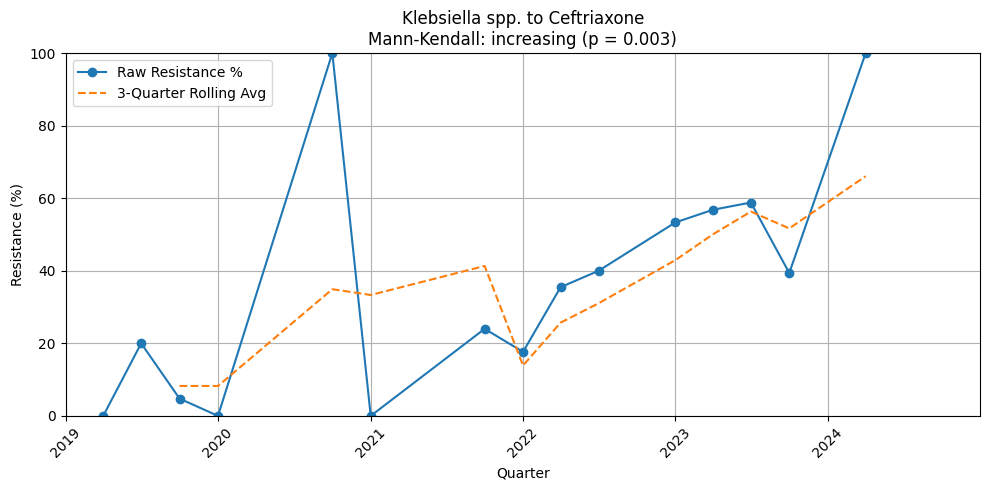

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


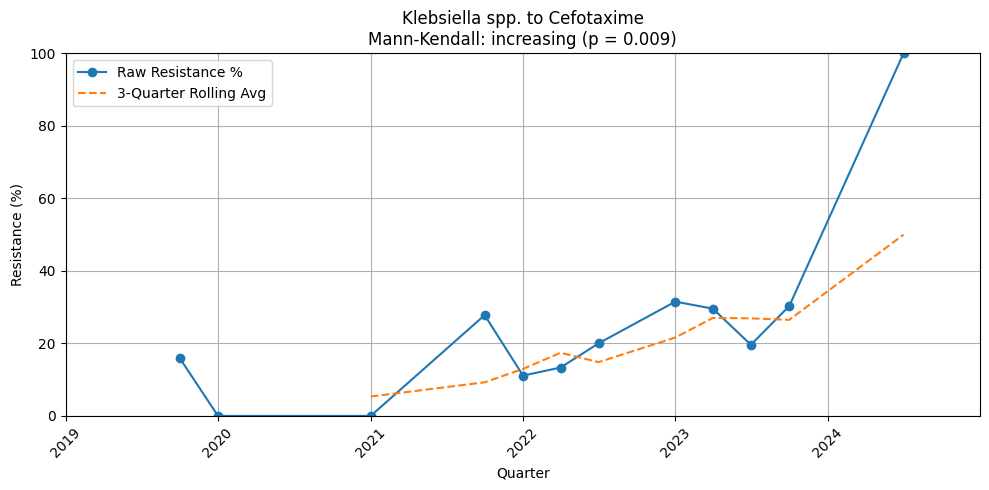

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


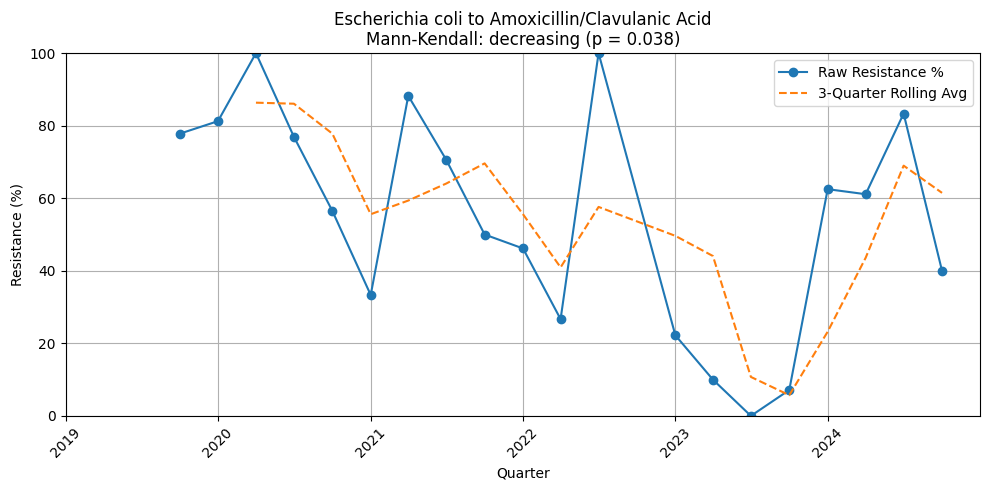

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


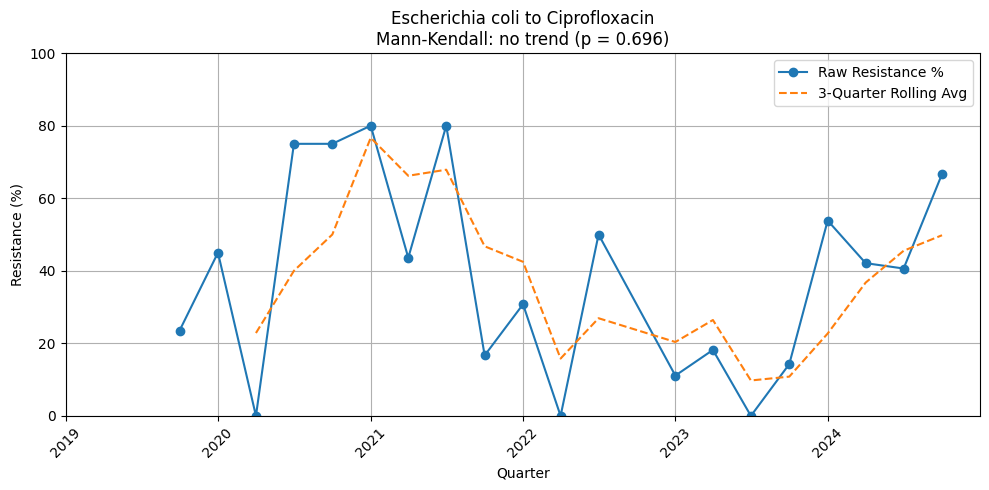

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


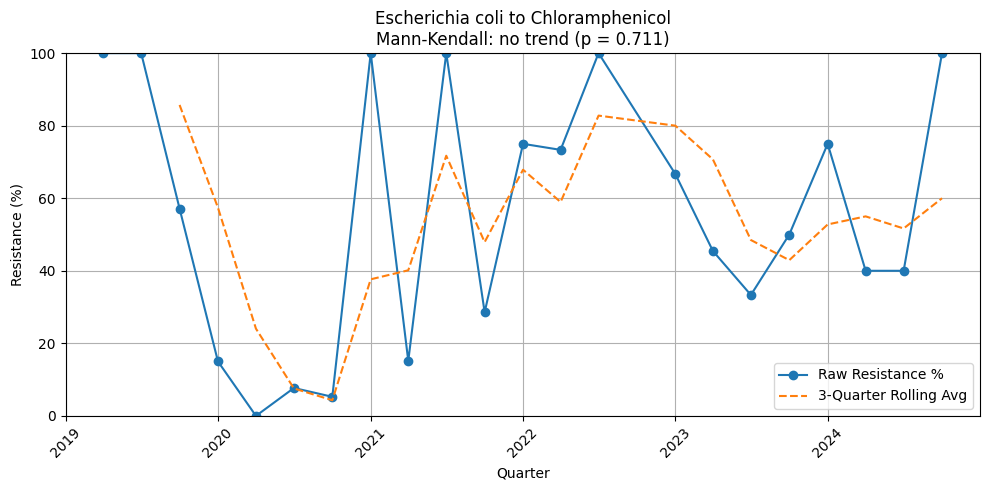

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


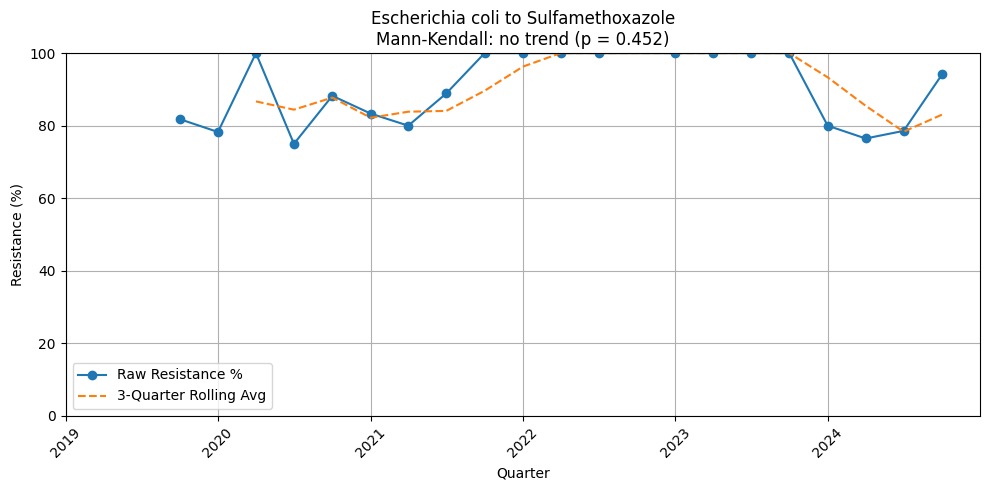

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


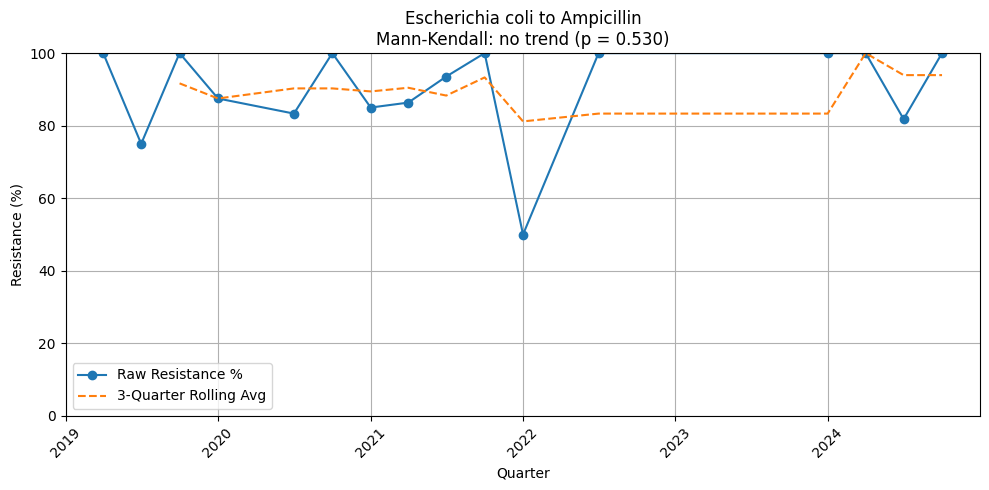

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


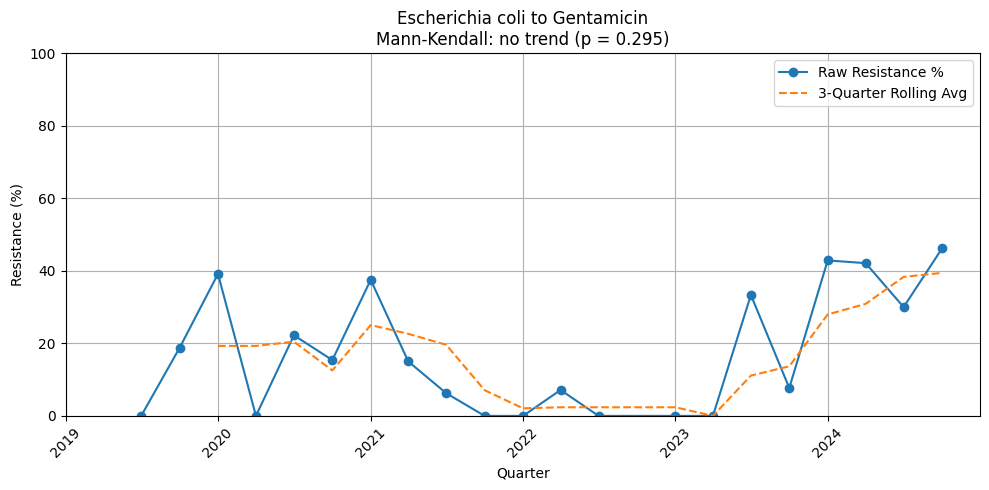

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


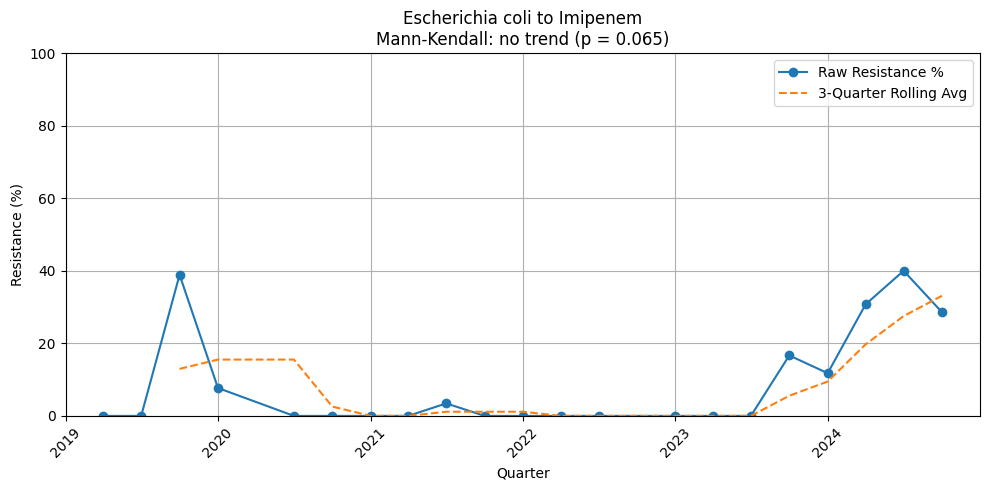

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


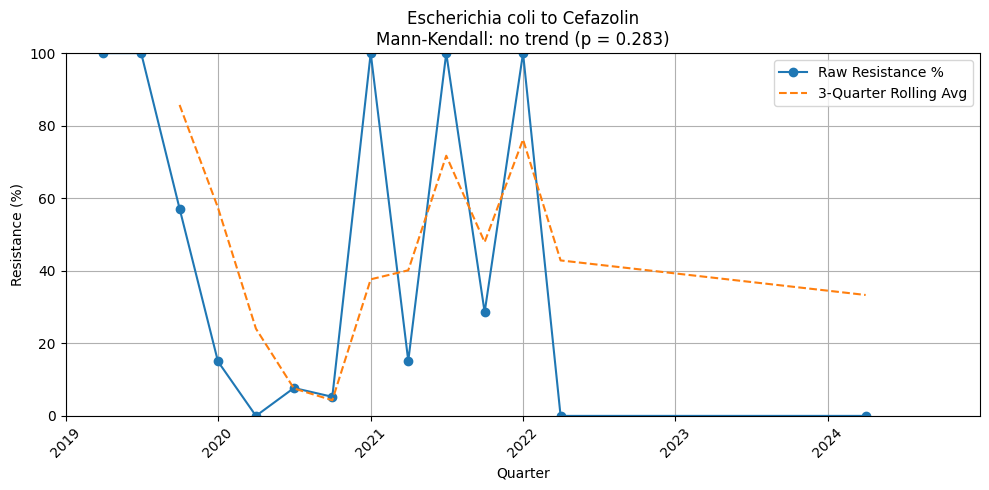

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


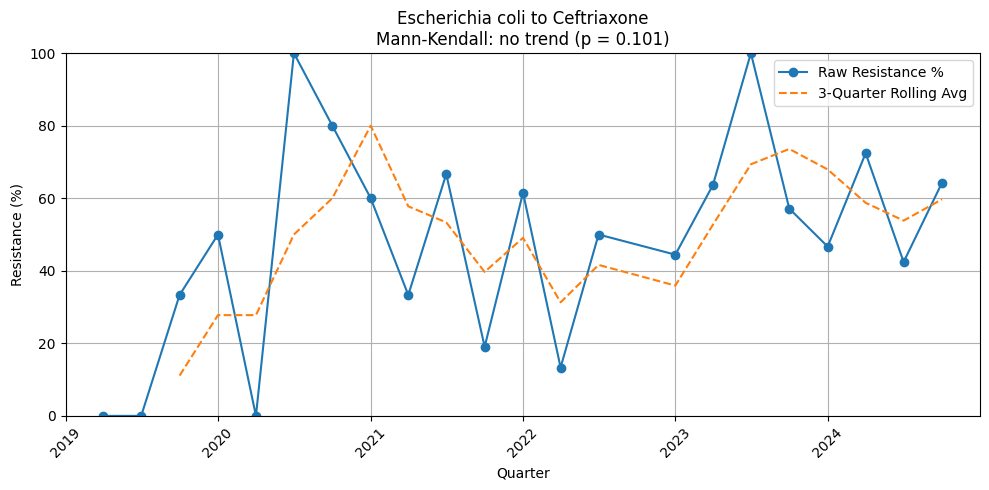

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


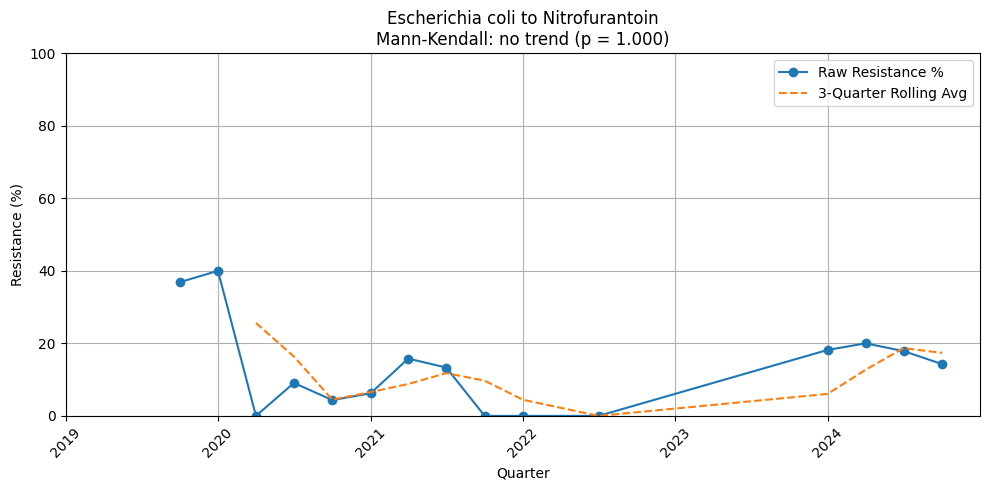

<ipython-input-89-f34a5b07517c>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))


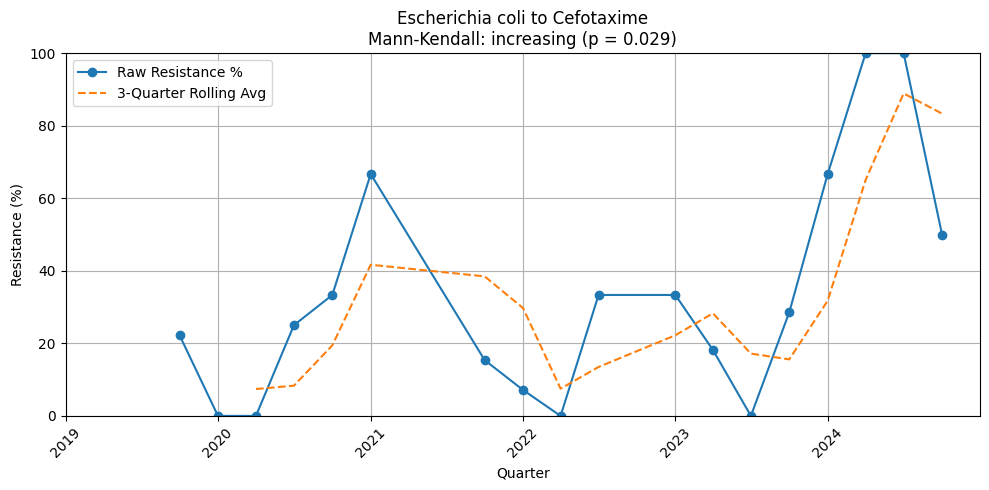

            Organism                   Antibiotic       Trend  p-value  \
0    Klebsiella spp.  Amoxicillin/Clavulanic Acid  decreasing   0.0068   
1    Klebsiella spp.                Ciprofloxacin    no trend   0.8164   
2    Klebsiella spp.              Chloramphenicol    no trend   0.1143   
3    Klebsiella spp.             Sulfamethoxazole    no trend   0.5482   
4    Klebsiella spp.                   Gentamicin    no trend   0.6308   
5    Klebsiella spp.                     Imipenem  increasing   0.0415   
6    Klebsiella spp.                  Ceftriaxone  increasing   0.0028   
7    Klebsiella spp.                   Cefotaxime  increasing   0.0090   
8   Escherichia coli  Amoxicillin/Clavulanic Acid  decreasing   0.0378   
9   Escherichia coli                Ciprofloxacin    no trend   0.6962   
10  Escherichia coli              Chloramphenicol    no trend   0.7106   
11  Escherichia coli             Sulfamethoxazole    no trend   0.4523   
12  Escherichia coli                  

In [89]:
import matplotlib.pyplot as plt
import pymannkendall as mk
import pandas as pd

# Preprocess: Create YearQuarter column
urine_data['Specimen date'] = pd.to_datetime(urine_data['Specimen date'])
urine_data['YearQuarter'] = urine_data['Specimen date'].dt.to_period('Q').astype(str)

# Initialize an empty list to collect Mann-Kendall results
mk_results = []

# Get unique organisms and antimicrobial agents
unique_organisms = urine_data['Organism'].unique()
antibiotic_columns_encoded = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]
antimicrobial_agents = list(set([col[:-2] for col in antibiotic_columns_encoded]))

# Get sorted list of quarters
quarters = sorted(urine_data['YearQuarter'].unique())

# Iterate over all organism-antibiotic combinations
for organism in unique_organisms:
    for agent in antimicrobial_agents:
        trend_data = []

        for q in quarters:
            df = urine_data[(urine_data['YearQuarter'] == q) & (urine_data['Organism'] == organism)]
            r_col, i_col, s_col = f'{agent}_R', f'{agent}_I', f'{agent}_S'

            if all(col in df.columns for col in [r_col, i_col, s_col]):
                R, I, S = df[r_col].sum(), df[i_col].sum(), df[s_col].sum()
                total = R + I + S

                if total > 0:
                    resistance_pct = (R + I) / total * 100
                    trend_data.append((q, resistance_pct))

        if len(trend_data) >= 12:  # Require at least 3 years of quarterly data
            quarters_list, percentages = zip(*trend_data)
            if all(isinstance(p, (int, float)) for p in percentages):
                mk_result = mk.original_test(percentages)

                mk_results.append({
                    'Organism': organism,
                    'Antibiotic': agent,
                    'Trend': mk_result.trend,
                    'p-value': round(mk_result.p, 4),
                    'Tau': round(mk_result.Tau, 4),
                    'S': getattr(mk_result, 'S', 'NA'),
                    'Var(S)': round(getattr(mk_result, 'VarS', 0), 4),
                })

                # Plot with rolling average
                df_plot = pd.DataFrame({'Quarter': quarters_list, 'Resistance': percentages})
                df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))
                df_plot.set_index('Quarter', inplace=True)
                # Fix: limit to 2024 + use non-centered rolling average
                df_plot = df_plot[df_plot.index.year <= 2024]
                df_plot['RollingAvg'] = df_plot['Resistance'].rolling(window=3).mean()


                plt.figure(figsize=(10, 5))
                plt.plot(df_plot.index, df_plot['Resistance'], marker='o', label='Raw Resistance %')
                plt.plot(df_plot.index, df_plot['RollingAvg'], linestyle='--', label='3-Quarter Rolling Avg')
                plt.title(f"{organism} to {agent}\nMann-Kendall: {mk_result.trend} (p = {mk_result.p:.3f})")
                plt.xlim(pd.Timestamp("2019-01-01"), pd.Timestamp("2024-12-31"))

                plt.xlabel("Quarter")
                plt.ylabel("Resistance (%)")
                plt.ylim(0, 100)
                plt.xticks(rotation=45)
                plt.grid(True)
                plt.legend()
                plt.tight_layout()
                plt.show()

# Convert to DataFrame
mk_results_df = pd.DataFrame(mk_results)
print(mk_results_df.head(20))  # View first few rows


<ipython-input-108-89703b47ff9b>:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))
<ipython-input-108-89703b47ff9b>:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))
<ipython-input-108-89703b47ff9b>:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()


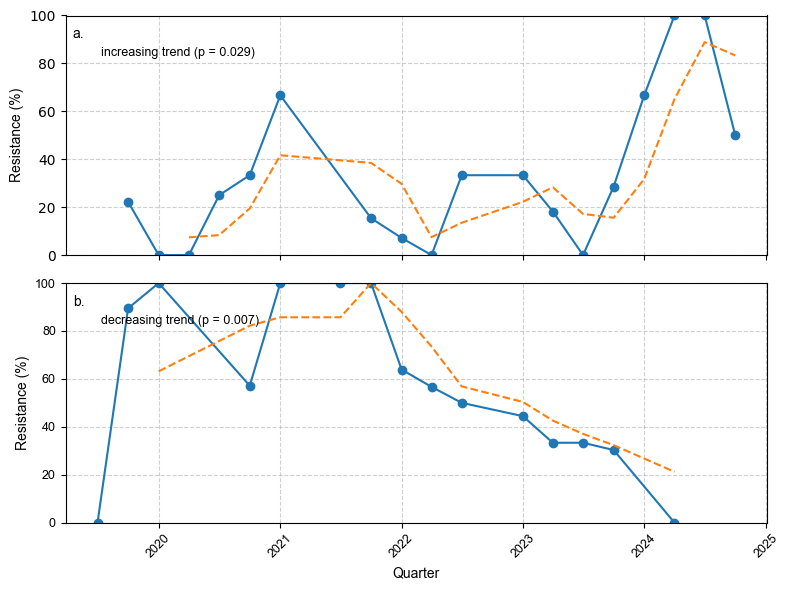

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [108]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd
import numpy as np

# Load Arial font
arial_font = FontProperties(fname='ARIAL.TTF')

# Organism-antibiotic pairs to show
selected_plots = [
    ('Escherichia coli', 'Cefotaxime'),
    ('Klebsiella spp.', 'Amoxicillin/Clavulanic Acid')
]

# Create figure
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)

for i, (organism, agent) in enumerate(selected_plots):
    trend_data = []

    for q in quarters:
        df = urine_data[(urine_data['YearQuarter'] == q) & (urine_data['Organism'] == organism)]
        r_col, i_col, s_col = f'{agent}_R', f'{agent}_I', f'{agent}_S'
        if all(col in df.columns for col in [r_col, i_col, s_col]):
            R, I, S = df[r_col].sum(), df[i_col].sum(), df[s_col].sum()
            total = R + I + S
            if total > 0:
                resistance_pct = (R + I) / total * 100
                trend_data.append((q, resistance_pct))

    if len(trend_data) >= 12:
        quarters_list, percentages = zip(*trend_data)
        df_plot = pd.DataFrame({'Quarter': quarters_list, 'Resistance': percentages})
        df_plot['Quarter'] = pd.to_datetime(df_plot['Quarter'].astype(str))
        df_plot.set_index('Quarter', inplace=True)
        df_plot = df_plot[df_plot.index.year <= 2024]
        df_plot['RollingAvg'] = df_plot['Resistance'].rolling(window=3).mean()

        ax = axes[i]
        ax.plot(df_plot.index, df_plot['Resistance'], marker='o')
        ax.plot(df_plot.index, df_plot['RollingAvg'], linestyle='--')
        ax.set_ylim(0, 100)
        ax.set_ylabel("Resistance (%)", fontsize=10, fontproperties=arial_font)
        ax.grid(True, linestyle='--', alpha=0.6)

        # Panel label: a. or b.
        label = chr(97 + i) + "."
        ax.text(0.01, 0.95, label, transform=ax.transAxes,
                fontsize=10, fontproperties=arial_font, verticalalignment='top')

        # Fetch trend + p-value
        result_row = mk_results_df[
            (mk_results_df['Organism'] == organism) &
            (mk_results_df['Antibiotic'] == agent)
        ]
        if not result_row.empty:
            trend = result_row.iloc[0]['Trend']
            pval = result_row.iloc[0]['p-value']
            trend_text = f"{trend} trend (p = {pval:.3f})"

            # Add trend+p-value inside the plot under label
            ax.text(0.05, 0.87, trend_text, transform=ax.transAxes,
                    fontsize=9, fontproperties=arial_font, verticalalignment='top')

# Shared x-axis label
axes[-1].set_xlabel("Quarter", fontsize=10, fontproperties=arial_font)
plt.xticks(rotation=45, fontproperties=arial_font, fontsize=9)
plt.yticks(fontproperties=arial_font, fontsize=9)

# Remove legends
for ax in axes:
    ax.legend().remove()

# Save and show
plt.tight_layout()
plt.savefig("MRRH2024_Figure3.jpg", format='jpg', dpi=300)
plt.show()
#dowload the Figure
from google.colab import files
files.download("MRRH2024_Figure3.jpg")


In [109]:
# Filter for increasing and decreasing trends only
trend_df = mk_results_df[mk_results_df['Trend'].isin(['increasing', 'decreasing'])].copy()

# Optional: sort by organism or antibiotic
trend_df.sort_values(by=['Organism', 'Antibiotic'], inplace=True)

# Reset index for clean export
trend_df.reset_index(drop=True, inplace=True)

# Display table
print("📊 Organism–Antibiotic Combinations with Significant Trends (Increasing or Decreasing):")
display(trend_df)


📊 Organism–Antibiotic Combinations with Significant Trends (Increasing or Decreasing):


TypeError: 'module' object is not callable

In [ ]:
#display antibiotic
print(antibiotic_columns_encoded)

In [ ]:
import pandas as pd
import numpy as np # Import numpy for checking data types if needed

# Assuming urine_data is already loaded and preprocessed up to the YearQuarter creation
# ... (your code for creating urine_data and YearQuarter column) ...

# Initialize a list to collect pairs that *did not* meet the data criteria
not_meeting_criteria = []

# Get unique organisms and antimicrobial agents
unique_organisms = urine_data['Organism'].unique()
antibiotic_columns_encoded = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]
antimicrobial_agents = list(set([col[:-2] for col in antibiotic_columns_encoded]))

# Get sorted list of quarters
quarters = sorted(urine_data['YearQuarter'].unique())

# Iterate over all organism-antibiotic combinations
for organism in unique_organisms:
    for agent in antimicrobial_agents:
        trend_data = []

        # Collect data points for the current organism and antibiotic across quarters
        for q in quarters:
            df = urine_data[(urine_data['YearQuarter'] == q) & (urine_data['Organism'] == organism)]
            r_col, i_col, s_col = f'{agent}_R', f'{agent}_I', f'{agent}_S'

            if all(col in df.columns for col in [r_col, i_col, s_col]):
                 R, I, S = df[r_col].sum(), df[i_col].sum(), df[s_col].sum()
                 total = R + I + S

                 if total > 0:
                     # We don't need resistance_pct here, just the fact that data exists
                     trend_data.append((q, total)) # Append something to indicate data exists for this quarter

        # Check if the number of data points (quarters with data) is LESS THAN 12
        if len(trend_data) < 12:
            # If the criteria is not met, record the organism and antibiotic pair
            not_meeting_criteria.append({'Organism': organism, 'Antibiotic': agent, 'Quarters with Data': len(trend_data)})

In [ ]:
# Convert the list to a DataFrame for display
not_meeting_criteria_df = pd.DataFrame(not_meeting_criteria)

print("\nOrganism-Antibiotic Pairs Excluded from Trend Analysis (due to < 12 quarters of data):")
display(not_meeting_criteria_df)

In [ ]:
# Filter for no trend
no_trend_df = mk_results_df[mk_results_df['Trend'] == 'no trend'].copy()
print("\nResults with No Significant Trend:")
display(no_trend_df)

In [110]:
import pandas as pd
from IPython.display import display

# Define antibiotic classes
antibiotic_classes = {
    'Beta-lactams': ['Amoxicillin', 'Amoxicillin/Clavulanic Acid', 'Ampicillin', 'Azlocillin', 'Aztreonam',
                     'Cefaclor', 'Cefazolin', 'Ceftriaxone', 'Penicillin'],
    'Fluoroquinolones': ['Ciprofloxacin', 'Ofloxacin', 'Moxifloxacin'],
    'Aminoglycosides': ['Gentamicin'],
    'Macrolides': ['Clindamycin', 'Erythromycin'],
    'Tetracyclines': ['Chlortetracycline'],
    'Sulfonamides': ['Sulfamethoxazole'],
    'Carbapenems': ['Imipenem', 'Meropenem'],
    'Amphenicols': ['Chloramphenicol'],
    'Nitrofurans': ['Nitrofurantoin']
}

# Step 1: Assign resistant classes
resistant_classes_list = []
for _, row in urine_data.iterrows():
    resistant_classes = []
    for class_name, antibiotics in antibiotic_classes.items():
        for ab in antibiotics:
            if row.get(f"{ab}_R", 0) == 1 or row.get(f"{ab}_I", 0) == 1:
                resistant_classes.append(class_name)
                break
    resistant_classes_list.append(', '.join(resistant_classes))

urine_data['Resistant Classes'] = resistant_classes_list

# Step 2: Define fully susceptible isolates
def is_fully_susceptible(row):
    for ab_list in antibiotic_classes.values():
        for ab in ab_list:
            if row.get(f"{ab}_R", 0) == 1 or row.get(f"{ab}_I", 0) == 1:
                return False
    return True

urine_data['Fully Susceptible'] = urine_data.apply(is_fully_susceptible, axis=1)

# Step 3: Define MDR types
def determine_mdr_type(row):
    organism = str(row['Organism']).lower()
    mdr_types = []
    if any(o in organism for o in ['escherichia coli', 'klebsiella', 'citrobacter']) and \
       any(row.get(f"{ab}_R", 0) == 1 or row.get(f"{ab}_I", 0) == 1 for ab in ['Ceftriaxone', 'Ceftazidime', 'Cefotaxime']):
        mdr_types.append('ESBL')
    if 'staphylococcus aureus' in organism and \
       any(row.get(f"{ab}_R", 0) == 1 or row.get(f"{ab}_I", 0) == 1 for ab in ['Oxacillin', 'Cefoxitin 30 mg']):
        mdr_types.append('MRSA')
    if 'enterococcus' in organism and (row.get('Vancomycin_R', 0) == 1 or row.get('Vancomycin_I', 0) == 1):
        mdr_types.append('VRE')
    if 'klebsiella pneumoniae' in organism and \
       any(row.get(f"{ab}_R", 0) == 1 or row.get(f"{ab}_I", 0) == 1 for ab in ['Imipenem', 'Meropenem']):
        mdr_types.append('KPC')
    return ', '.join(mdr_types) if mdr_types else 'None'

urine_data['MDR Type'] = urine_data.apply(determine_mdr_type, axis=1)

# Step 4: Classify MDR Status
def classify_mdr(row):
    if row['Fully Susceptible']:
        return 'Susceptible'
    cleaned = [cls.strip() for cls in row['Resistant Classes'].split(',') if cls.strip()]
    return 'MDR' if len(cleaned) >= 3 else 'Non-MDR'

urine_data['MDR Status'] = urine_data.apply(classify_mdr, axis=1)

# Step 5: Summarize and calculate percentage
summary_table = urine_data.groupby(['MDR Status', 'MDR Type']).size().reset_index(name='Count')
total_isolates = summary_table['Count'].sum()
summary_table['Percent'] = ((summary_table['Count'] / total_isolates) * 100).round(1)

# Adjust last row if needed to sum exactly to 100%
percent_diff = 100 - summary_table['Percent'].sum()
if abs(percent_diff) > 0.01:
    summary_table.loc[summary_table.index[-1], 'Percent'] += percent_diff

# Show summary
print("MDR Status Summary:")
display(summary_table)

# Filter and display MDR isolates (show MDR type clearly)
mdr_isolates = urine_data[urine_data['MDR Status'] == 'MDR']
display(mdr_isolates[['Identification number', 'Specimen number', 'Organism',
                      'Resistant Classes', 'MDR Status', 'MDR Type']].sort_values(by='MDR Type'))


MDR Status Summary:


,MDR Status,MDR Type,Count,Percent
0,MDR,ESBL,197,21.0
1,MDR,"ESBL, KPC",2,0.2
2,MDR,KPC,1,0.1
3,MDR,None,158,16.8
4,Non-MDR,ESBL,178,19.0
5,Non-MDR,KPC,1,0.1
6,Non-MDR,None,356,37.9
7,Susceptible,None,46,4.9


,Identification number,Specimen number,Organism,Resistant Classes,MDR Status,MDR Type
22165,0-0074,NaN,Klebsiella spp.,"Beta-lactams, Sulfonamides, Carbapenems, Amphe...",MDR,ESBL
22594,0-0453,NaN,Klebsiella spp.,"Beta-lactams, Sulfonamides, Amphenicols",MDR,ESBL
22585,0-0444,NaN,Klebsiella spp.,"Beta-lactams, Aminoglycosides, Sulfonamides, A...",MDR,ESBL
22577,0-0437,NaN,Klebsiella spp.,"Beta-lactams, Aminoglycosides, Sulfonamides, C...",MDR,ESBL
22575,0-0435,NaN,Klebsiella spp.,"Beta-lactams, Sulfonamides, Amphenicols",MDR,ESBL
...,...,...,...,...,...,...
1356,0-0943,NaN,Escherichia coli,"Beta-lactams, Fluoroquinolones, Sulfonamides",MDR,None
1362,0-0939,NaN,Escherichia coli,"Beta-lactams, Fluoroquinolones, Aminoglycoside...",MDR,None
1381,0-0930,NaN,Escherichia coli,"Beta-lactams, Fluoroquinolones, Aminoglycoside...",MDR,None
22618,0-0476,NaN,Klebsiella spp.,"Beta-lactams, Sulfonamides, Amphenicols",MDR,None


In [111]:
import pandas as pd
from IPython.display import display

# Load your data into urine_data, e.g.
# urine_data = pd.read_csv("your_file.csv")

# Define antibiotic classes
antibiotic_classes = {
    'Beta-lactams': ['Amoxicillin', 'Amoxicillin/Clavulanic Acid', 'Ampicillin', 'Azlocillin', 'Aztreonam',
                     'Cefaclor', 'Cefazolin', 'Ceftriaxone', 'Penicillin'],
    'Fluoroquinolones': ['Ciprofloxacin', 'Ofloxacin', 'Moxifloxacin'],
    'Aminoglycosides': ['Gentamicin'],
    'Macrolides': ['Clindamycin', 'Erythromycin'],
    'Sulfonamides': ['Sulfamethoxazole'],
    'Carbapenems': ['Imipenem', 'Meropenem'],
    'Amphenicols': ['Chloramphenicol'],
    'Nitrofurans': ['Nitrofurantoin']
}

# Step 1: Assign resistant classes per isolate
def get_resistant_classes(row):
    resistant = []
    for class_name, agents in antibiotic_classes.items():
        for ab in agents:
            if row.get(f"{ab}_R", 0) == 1 or row.get(f"{ab}_I", 0) == 1:
                resistant.append(class_name)
                break
    return resistant

urine_data['Resistant Classes'] = urine_data.apply(get_resistant_classes, axis=1)

# Step 2: Fully susceptible label
urine_data['Fully Susceptible'] = urine_data['Resistant Classes'].apply(lambda x: len(x) == 0)

# Step 3: Detect mechanism-based MDR types
def detect_mdr_mechanisms(row):
    organism = str(row['Organism']).lower()
    types = []
    if any(org in organism for org in ['escherichia coli', 'klebsiella', 'citrobacter']):
        if any(row.get(f"{ab}_R", 0) == 1 or row.get(f"{ab}_I", 0) == 1 for ab in ['Ceftriaxone', 'Ceftazidime', 'Cefotaxime']):
            types.append('ESBL')
    if 'staphylococcus aureus' in organism:
        if any(row.get(f"{ab}_R", 0) == 1 or row.get(f"{ab}_I", 0) == 1 for ab in ['Oxacillin', 'Cefoxitin 30 mg']):
            types.append('MRSA')
    if 'enterococcus' in organism:
        if row.get('Vancomycin_R', 0) == 1 or row.get('Vancomycin_I', 0) == 1:
            types.append('VRE')
    if 'klebsiella pneumoniae' in organism:
        if any(row.get(f"{ab}_R", 0) == 1 or row.get(f"{ab}_I", 0) == 1 for ab in ['Imipenem', 'Meropenem']):
            types.append('KPC')
    return ', '.join(types) if types else 'None'

urine_data['MDR Type'] = urine_data.apply(detect_mdr_mechanisms, axis=1)

# Step 4: WHO-compliant MDR/XDR/PDR classification
def classify_resistance_profile(row):
    if row['Fully Susceptible']:
        return 'Susceptible'
    total_classes = len(antibiotic_classes)
    resistant_class_count = len(set(row['Resistant Classes']))
    if resistant_class_count == total_classes:
        return 'PDR'
    elif total_classes - resistant_class_count <= 2:
        return 'XDR'
    elif resistant_class_count >= 3:
        return 'MDR'
    else:
        return 'Non-MDR'

urine_data['MDR Status'] = urine_data.apply(classify_resistance_profile, axis=1)

# Step 5: Override logic for known mechanisms
def enforce_mechanism_override(row):
    if row['MDR Status'] in ['Susceptible', 'Non-MDR']:
        if any(m in row['MDR Type'] for m in ['ESBL', 'KPC', 'MRSA', 'VRE']):
            return 'MDR'
    return row['MDR Status']

urine_data['MDR Status'] = urine_data.apply(enforce_mechanism_override, axis=1)

# Step 6: Annotate reasoning (optional)
def explain_mdr_reason(row):
    if row['Fully Susceptible']:
        return 'Fully Susceptible'
    elif any(m in row['MDR Type'] for m in ['ESBL', 'KPC', 'MRSA', 'VRE']):
        return 'Mechanism-based MDR'
    elif row['MDR Status'] == 'PDR':
        return 'All classes resistant'
    elif row['MDR Status'] == 'XDR':
        return 'Only 0–2 classes susceptible'
    elif row['MDR Status'] == 'MDR':
        return '≥3 classes resistant'
    return 'Resistant to <3 classes'

urine_data['MDR Reason'] = urine_data.apply(explain_mdr_reason, axis=1)

# Step 7: Summary output with percentages
summary_table = urine_data.groupby(['MDR Status', 'MDR Type']).size().reset_index(name='Count')
total_isolates = len(urine_data)
summary_table['Percent'] = (summary_table['Count'] / total_isolates * 100).round(2)

# Normalize percentages to sum to 100% if needed
summary_table['Percent'] = (summary_table['Percent'] / summary_table['Percent'].sum() * 100).round(2)

# Final display
display(summary_table)


,MDR Status,MDR Type,Count,Percent
0,MDR,ESBL,374,39.82
1,MDR,"ESBL, KPC",1,0.11
2,MDR,KPC,1,0.11
3,MDR,None,158,16.83
4,Non-MDR,None,356,37.90
5,Susceptible,None,46,4.90
6,XDR,ESBL,1,0.11
7,XDR,"ESBL, KPC",1,0.11
8,XDR,KPC,1,0.11


In [ ]:
#print unique mdrstatus
print(urine_data['MDR Status'].unique())

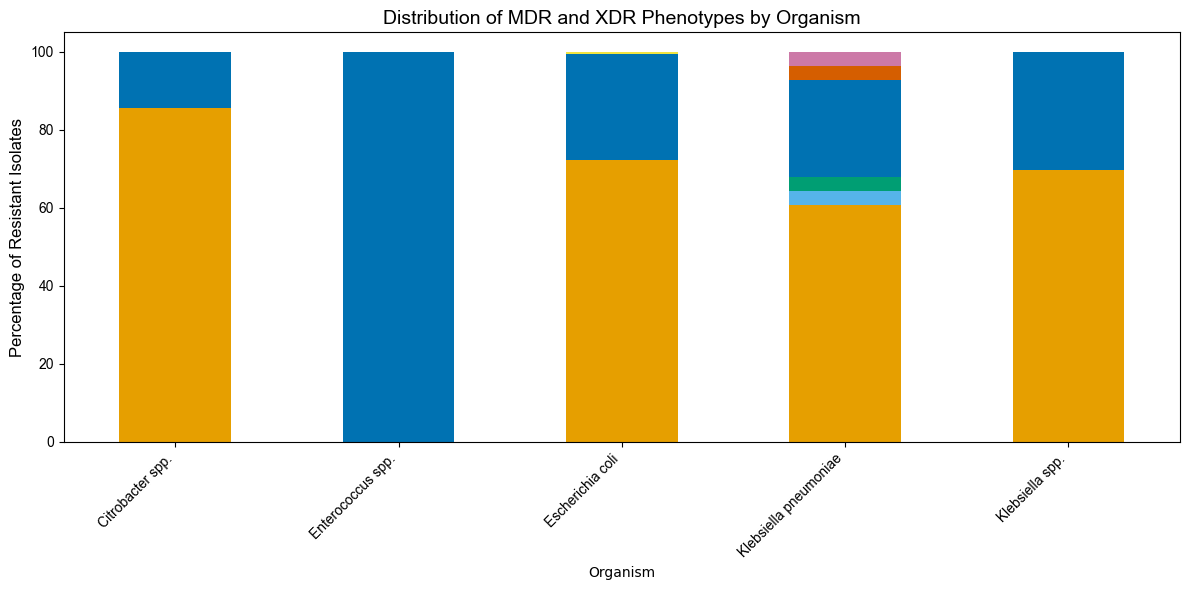

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np

# Load Arial font (adjust path if needed)
arial_font = FontProperties(fname='ARIAL.TTF')

# Step 1: Filter resistant isolates (MDR + XDR)
res_data = urine_data[urine_data['MDR Status'].isin(['MDR', 'XDR'])].copy()

# Step 2: Standardize missing mechanism
res_data['MDR Type'] = res_data['MDR Type'].replace({'None': 'No detected mechanism'})

# Step 3: Combine status and type
res_data['Phenotypic Label'] = res_data['MDR Status'] + ': ' + res_data['MDR Type']

# Step 4: Count phenotypes
phenotype_counts = res_data.groupby(['Organism', 'Phenotypic Label']).size().unstack(fill_value=0)

# Step 5: Convert to percentages
phenotype_percentages = phenotype_counts.div(phenotype_counts.sum(axis=1), axis=0) * 100

# Step 6: Define color palette
color_palette = ['#E69F00', '#56B4E9', '#009E73', '#0072B2',
                 '#F0E442', '#D55E00', '#CC79A7', '#999999',
                 '#CC9900', '#33CCFF', '#6600CC']

# Step 7: Plot (legend removed)
fig, ax = plt.subplots(figsize=(12, 6))
phenotype_percentages.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=color_palette[:phenotype_percentages.shape[1]]
)
ax.get_legend().remove()  # ⛔ Remove legend

# Labels
ax.set_ylabel('Percentage of Resistant Isolates', fontproperties=arial_font, fontsize=12)
ax.set_title('Distribution of MDR and XDR Phenotypes by Organism', fontproperties=arial_font, fontsize=14)
ax.set_xticklabels(phenotype_percentages.index, rotation=45, ha='right', fontproperties=arial_font, fontsize=10)
plt.yticks(fontproperties=arial_font, fontsize=10)

# Save and show
plt.tight_layout()
plt.savefig("MRRH2024_Figure4.jpg", format='jpg', dpi=300)
plt.show()
#dowload the Figure
from google.colab import files
files.download("MRRH2024_Figure4.jpg")


In [ ]:
urine_data.head()

<ipython-input-116-ca7aef993b05>:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '86.31578947368422' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  percentage_df.loc[org, cls] = perc
<ipython-input-116-ca7aef993b05>:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '17.543859649122805' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  percentage_df.loc[org, cls] = perc
<ipython-input-116-ca7aef993b05>:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.789473684210526' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  percentage_df.loc[org, cls] = perc
<ipython-input-116-ca7aef993b05>:53: FutureWarning: Setting an item of 

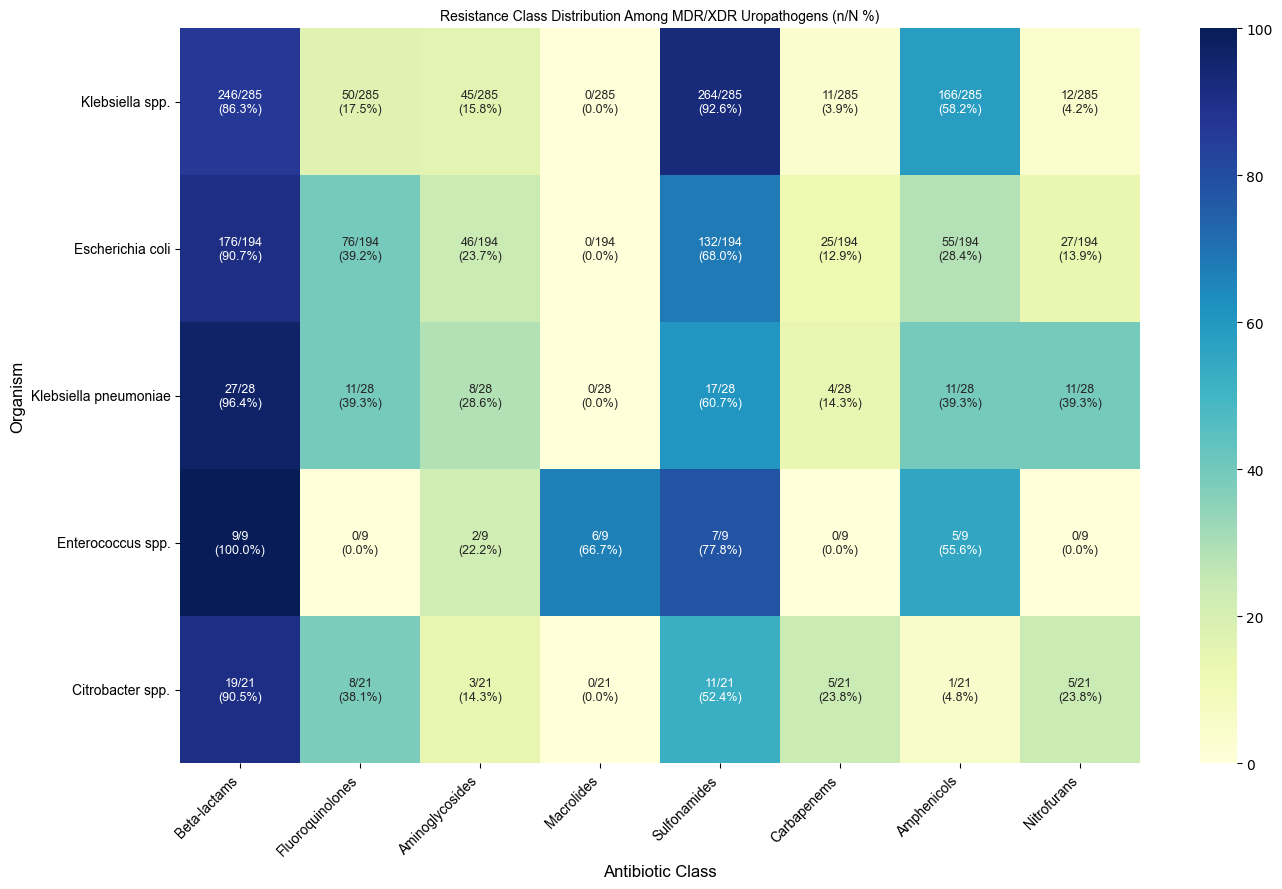

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties

# Load Arial font
arial_font = FontProperties(fname='ARIAL.TTF')

# ---- Step 0: Load your data and define antibiotic_classes before running this ----
# Example:
# urine_data = pd.read_csv("your_data.csv")
# antibiotic_classes = {'Beta-lactams': [...], 'Fluoroquinolones': [...], ...}

# Step 1: Recalculate 'Resistant Classes'
resistant_classes_list = []
for _, row in urine_data.iterrows():
    resistant_classes = []
    for class_name, antibiotics in antibiotic_classes.items():
        for ab in antibiotics:
            if row.get(f"{ab}_R", 0) == 1 or row.get(f"{ab}_I", 0) == 1:
                resistant_classes.append(class_name)
                break
    resistant_classes_list.append(', '.join(resistant_classes))

urine_data['Resistant Classes'] = resistant_classes_list

# Step 2: Filter MDR and XDR isolates
filtered_data = urine_data[urine_data['MDR Status'].isin(['MDR', 'XDR'])].copy()

# Step 3: Count totals and resistance
organism_totals = filtered_data['Organism'].value_counts().to_dict()
organism_class_counts = {}
for _, row in filtered_data.iterrows():
    organism = row['Organism']
    classes = row['Resistant Classes'].split(", ") if pd.notnull(row['Resistant Classes']) else []
    if organism not in organism_class_counts:
        organism_class_counts[organism] = {cls: 0 for cls in antibiotic_classes}
    for cls in classes:
        if cls in organism_class_counts[organism]:
            organism_class_counts[organism][cls] += 1

# Step 4: Create DataFrames
count_df = pd.DataFrame.from_dict(organism_class_counts, orient='index').fillna(0).astype(int)
annot_df = count_df.copy().astype(str)
percentage_df = count_df.copy()

for org in count_df.index:
    total = organism_totals.get(org, 0)
    for cls in count_df.columns:
        n = count_df.loc[org, cls]
        perc = (n / total * 100) if total > 0 else 0
        annot_df.loc[org, cls] = f"{n}/{total}\n({perc:.1f}%)"
        percentage_df.loc[org, cls] = perc

# Step 5: Plot
plt.figure(figsize=(14, 9))
sns.heatmap(
    percentage_df,
    annot=annot_df,
    fmt='',
    cmap='YlGnBu',
    annot_kws={"size": 9, "fontproperties": arial_font},
    cbar=True
)
plt.xlabel("Antibiotic Class", fontsize=12, fontproperties=arial_font)
plt.ylabel("Organism", fontsize=12, fontproperties=arial_font)
plt.title("Resistance Class Distribution Among MDR/XDR Uropathogens (n/N %)", fontsize=14, fontproperties=arial_font)
plt.xticks(rotation=45, ha='right', fontsize=10, fontproperties=arial_font)
plt.yticks(rotation=0, fontsize=10, fontproperties=arial_font)
# Save and show
plt.tight_layout()
plt.savefig("MRRH2024_Figure5.jpg", format='jpg', dpi=300)
plt.show()
#dowload the Figure
from google.colab import files
files.download("MRRH2024_Figure5.jpg")


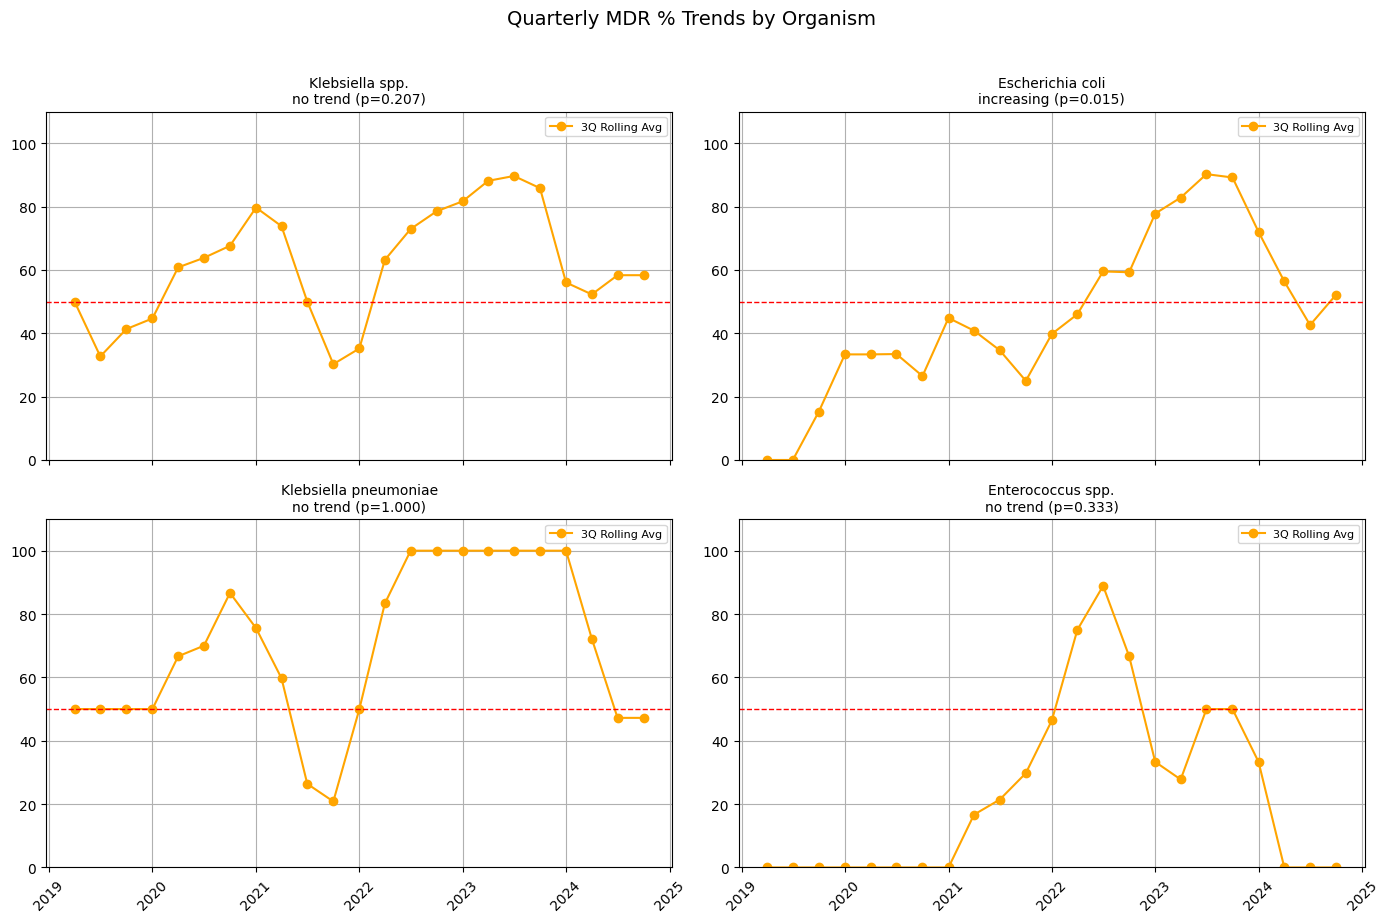

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import pymannkendall as mk
import numpy as np

# Step 1: Prepare datetime and quarter
urine_data['Specimen date'] = pd.to_datetime(urine_data['Specimen date'])
urine_data['YearQuarter'] = urine_data['Specimen date'].dt.to_period('Q').astype(str)
urine_data['Is_MDR'] = (urine_data['MDR Status'] == 'MDR').astype(int)

# Step 2: Define complete quarter-organism grid
organisms = urine_data['Organism'].unique()
all_quarters = pd.period_range(
    start=urine_data['Specimen date'].min(),
    end=urine_data['Specimen date'].max(),
    freq='Q'
).astype(str)

plot_dict = {}

# Step 3: Process each organism
for organism in organisms:
    quarter_data = []

    for q in all_quarters:
        df_q = urine_data[(urine_data['YearQuarter'] == q) & (urine_data['Organism'] == organism)]
        total = len(df_q)
        if total > 0:
            mdr_pct = df_q['Is_MDR'].mean() * 100
        else:
            mdr_pct = np.nan  # Mark missing values
        quarter_data.append((q, mdr_pct))

    # Create dataframe and convert quarters
    df_plot = pd.DataFrame(quarter_data, columns=['Quarter', 'MDR %'])
    df_plot['Quarter'] = pd.PeriodIndex(df_plot['Quarter'], freq='Q').to_timestamp()
    df_plot.set_index('Quarter', inplace=True)

    # Run Mann-Kendall on original values (not interpolated)
    if df_plot['MDR %'].notna().sum() >= 12:
        mk_result = mk.original_test(df_plot['MDR %'].dropna())
        trend_label = f"{mk_result.trend} (p={mk_result.p:.3f})"

        # Interpolate missing quarters
        df_plot['MDR %'] = df_plot['MDR %'].interpolate(method='linear', limit_direction='both')

        # Rolling average on interpolated data
        df_plot['RollingAvg'] = df_plot['MDR %'].rolling(window=3, min_periods=1).mean()

        # Store for plotting
        plot_dict[organism] = {'df': df_plot, 'label': trend_label}

# Step 4: Plot with 2 subplots per row
n_orgs = len(plot_dict)
cols = 2
rows = int(np.ceil(n_orgs / cols))

fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 4.5 * rows), sharex=True)
axes = axes.flatten()

for idx, (organism, content) in enumerate(plot_dict.items()):
    ax = axes[idx]
    df = content['df']

    # Plot rolling average only
    ax.plot(df.index, df['RollingAvg'], linestyle='-', marker='o', color='orange', label='3Q Rolling Avg')
    ax.set_title(f"{organism}\n{content['label']}", fontsize=10)
    ax.set_ylim(0, 110)
    ax.axhline(50, color='red', linestyle='--', linewidth=1)
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(fontsize=8)

# Hide unused subplots
for idx in range(len(plot_dict), len(axes)):
    axes[idx].axis('off')

plt.suptitle("Quarterly MDR % Trends by Organism ", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


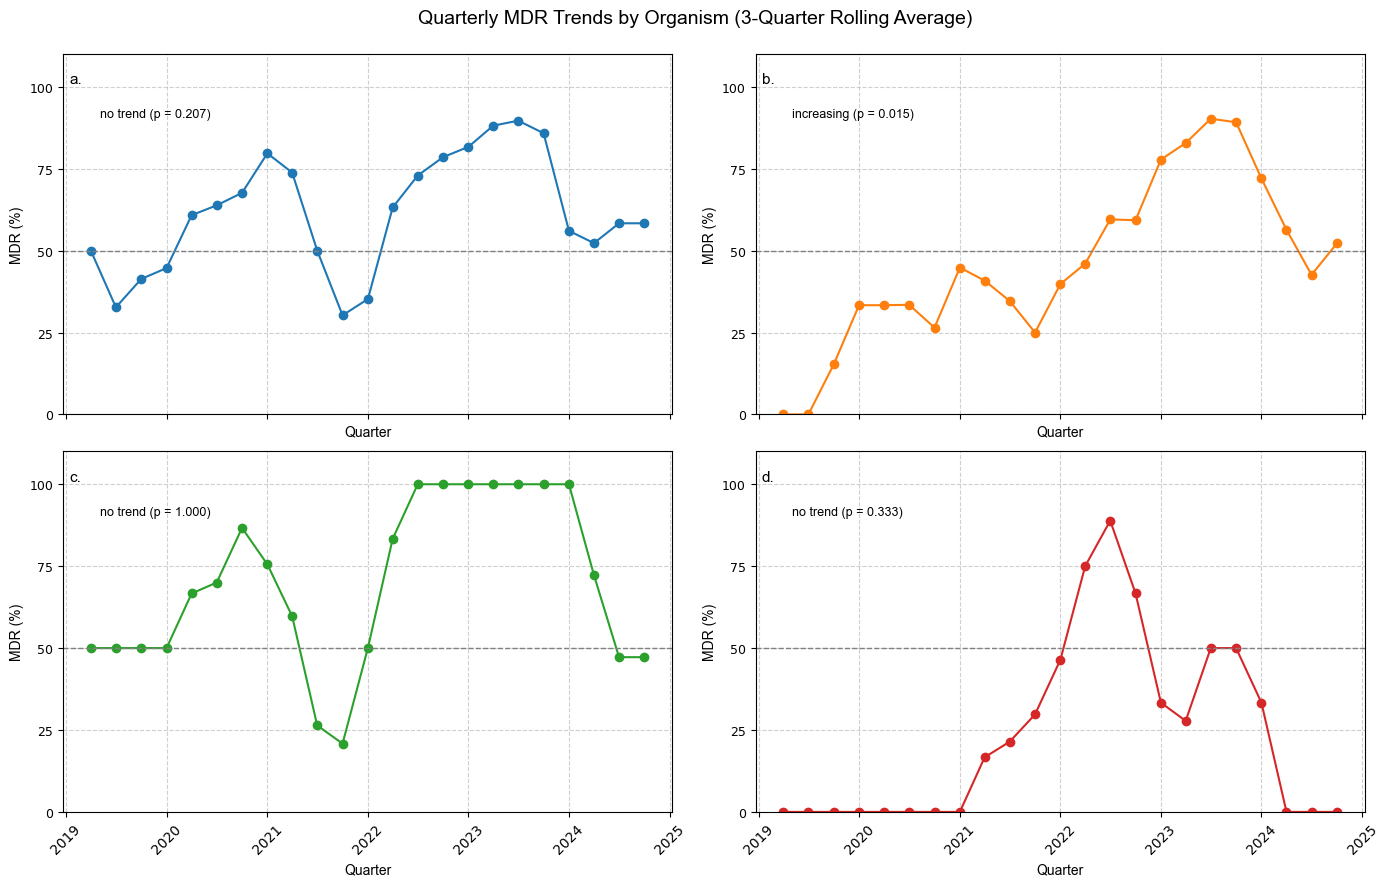

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [120]:
# --- Install pymannkendall if needed ---
!pip install pymannkendall --quiet

# --- Imports ---
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pymannkendall as mk
from google.colab import files

# --- Load Arial font ---
arial_font = FontProperties(fname='ARIAL.TTF')  # Upload this font in Colab

# --- Date and quarter processing ---
urine_data['Specimen date'] = pd.to_datetime(urine_data['Specimen date'])
urine_data['YearQuarter'] = urine_data['Specimen date'].dt.to_period('Q').astype(str)
urine_data['Is_MDR'] = (urine_data['MDR Status'] == 'MDR').astype(int)

organisms = urine_data['Organism'].unique()
all_quarters = pd.period_range(
    start=urine_data['Specimen date'].min(),
    end=urine_data['Specimen date'].max(),
    freq='Q'
).astype(str)

plot_dict = {}

# --- Calculate MDR % and Mann-Kendall ---
for organism in organisms:
    quarter_data = []
    for q in all_quarters:
        df_q = urine_data[(urine_data['YearQuarter'] == q) & (urine_data['Organism'] == organism)]
        total = len(df_q)
        mdr_pct = df_q['Is_MDR'].mean() * 100 if total > 0 else np.nan
        quarter_data.append((q, mdr_pct))

    df_plot = pd.DataFrame(quarter_data, columns=['Quarter', 'MDR %'])
    df_plot['Quarter'] = pd.PeriodIndex(df_plot['Quarter'], freq='Q').to_timestamp()
    df_plot.set_index('Quarter', inplace=True)

    if df_plot['MDR %'].notna().sum() >= 12:
        mk_result = mk.original_test(df_plot['MDR %'].dropna())
        label = f"{mk_result.trend} (p = {mk_result.p:.3f})"
        df_plot['MDR %'] = df_plot['MDR %'].interpolate(method='linear', limit_direction='both')
        df_plot['RollingAvg'] = df_plot['MDR %'].rolling(window=3, min_periods=1).mean()
        plot_dict[organism] = {'df': df_plot, 'label': label}

# --- Plotting ---
n_orgs = len(plot_dict)
cols = 2
rows = int(np.ceil(n_orgs / cols))
fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 4.5 * rows), sharex=True)
axes = axes.flatten()
colors = plt.cm.tab10.colors

for idx, (organism, content) in enumerate(plot_dict.items()):
    ax = axes[idx]
    df = content['df']
    color = colors[idx % len(colors)]

    ax.plot(df.index, df['RollingAvg'], linestyle='-', marker='o', color=color)

    # Panel letter a. b. c.
    ax.text(0.01, 0.95, f"{chr(97 + idx)}.", transform=ax.transAxes,
            fontsize=11, fontproperties=arial_font, va='top')

    # p-value text only
    ax.text(0.06, 0.85, content['label'], transform=ax.transAxes,
            fontsize=9, fontproperties=arial_font, va='top')

    ax.set_ylim(0, 110)
    ax.axhline(50, color='gray', linestyle='--', linewidth=1)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylabel("MDR (%)", fontsize=10, fontproperties=arial_font)
    ax.set_xlabel("Quarter", fontsize=10, fontproperties=arial_font)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', labelsize=9)
    ax.set_yticks([0, 25, 50, 75, 100])

# Hide unused axes
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

# --- Final layout ---
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.suptitle("Quarterly MDR Trends by Organism (3-Quarter Rolling Average)", fontsize=14, fontproperties=arial_font)

# --- Save and download ---
plt.savefig("MRRH2024_Figure6.jpg", dpi=300, format='jpg')
plt.show()
files.download("MRRH2024_Figure6.jpg")


In [ ]:
#unique urine specimen
print(urine_data['Specimen type'].unique())

In [ ]:
import pandas as pd
from IPython.display import display  # Import display function
from google.colab import data_table

data_table.enable_dataframe_formatter()
data_table.enable_dataframe_formatter()

# ... (your existing code to load and preprocess urine_data) ...

# Get unique organisms and antimicrobial agents
unique_organisms = urine_data['Organism'].unique()
antibiotic_columns = urine_data.columns[urine_data.columns.str.endswith(('_I', '_R', '_S'))]
antimicrobial_agents = list(set([col[:-2] for col in antibiotic_columns]))

# Create a dictionary to store the table data
table_data = {'Bacterial Isolates': [], 'R0 No (%)': [], 'R1 No (%)': [], 'R2 No (%)': [],
              'R3 No (%)': [], 'R4 No (%)': [], 'R5 No (%)': [], 'R6 No (%)': [], '>R7 No (%)': []}

# Iterate through unique organisms
for organism in unique_organisms:
    # Get organism count, handling potential KeyError
    organism_count = urine_data['Organism'].value_counts().get(organism, 0)

    table_data['Bacterial Isolates'].append(f"{organism} ({organism_count})")

    # Calculate resistance counts for each category directly
    resistance_counts = [0] * 8  # Initialize counts for R0 to >R7

    for i in range(len(resistance_counts)):
        # Calculate count for current resistance level (R0 to >R7)
        count = 0
        for _, row in urine_data[urine_data['Organism'] == organism].iterrows():
            resistance_level = 0
            for agent in antimicrobial_agents:
                if agent + '_I' in row and agent + '_R' in row:
                    if row[agent + '_I'] == 1 or row[agent + '_R'] == 1:
                        resistance_level += 1

            if resistance_level == i:  # Check if resistance level matches current category
                count += 1
            elif resistance_level > 6 and i == 7: # For >R7 category
                count += 1

        resistance_counts[i] = count

    # Calculate percentages and format for the table
    total_isolates = urine_data['Organism'].value_counts().get(organism, 0)  # Handle KeyError
    for i in range(len(resistance_counts)):
        percentage = (resistance_counts[i] / total_isolates) * 100 if total_isolates else 0
        table_data[f"R{i} No (%)" if i <= 6 else ">R7 No (%)"].append(f"{resistance_counts[i]} ({percentage:.1f}%)")

# Create the DataFrame
multi_drug_resistance_table = pd.DataFrame(table_data)

# Display the table using data_table formatter
display(multi_drug_resistance_table)

In [ ]:
urine_data.head()

In [ ]:
#print unique specimen type
print(urine_data['Specimen type'].unique())

In [ ]:
import pandas as pd

# STEP 0: Normalize specimen labels
specimen_map = {
    'ur': 'Midstream urine',
    'urine': 'Midstream urine',
    'ue': 'Midstream urine',
    'uc': 'Catheter'
}
urine_data['Specimen Type'] = urine_data['Specimen type'].str.lower().map(specimen_map)

# STEP 1: Count & Percentage of Specimen Types
specimen_counts = urine_data['Specimen Type'].value_counts().reset_index()
specimen_counts.columns = ['Specimen Type', 'Count']
specimen_counts['Percentage'] = round(100 * specimen_counts['Count'] / specimen_counts['Count'].sum(), 1)

# STEP 2: Organism Distribution per Specimen Type
organism_counts = urine_data.groupby(['Specimen Type', 'Organism']).size().reset_index(name='Count')
organism_totals = organism_counts.groupby('Specimen Type')['Count'].transform('sum')
organism_counts['Percentage'] = round(100 * organism_counts['Count'] / organism_totals, 1)

# STEP 3: Resistance Percentage by Specimen
if 'Resistant_to_Any' not in urine_data.columns:
    raise ValueError("You must have a 'Resistant_to_Any' column with True/False values indicating resistance.")

resistance_summary = urine_data.groupby('Specimen Type')['Resistant_to_Any'].agg(['sum', 'count']).reset_index()
resistance_summary['Resistance %'] = round(100 * resistance_summary['sum'] / resistance_summary['count'], 1)
resistance_summary.rename(columns={'sum': 'Resistant', 'count': 'Total'}, inplace=True)

# STEP 4: MDR Percentage by Specimen
if 'MDR Status' not in urine_data.columns:
    raise ValueError("You must have an 'MDR Status' column with values like 'MDR', 'Non-MDR'.")

mdr_summary = urine_data.groupby('Specimen Type')['MDR Status'].value_counts().unstack().fillna(0)
mdr_summary['Total'] = mdr_summary.sum(axis=1)
mdr_summary['MDR %'] = round(100 * mdr_summary.get('MDR', 0) / mdr_summary['Total'], 1)
mdr_summary = mdr_summary.reset_index()

# STEP 5: Organism-wise Resistance and MDR Comparison
organism_resistance = urine_data.groupby(['Specimen Type', 'Organism'])['Resistant_to_Any'].mean().reset_index()
organism_resistance['Resistance %'] = round(100 * organism_resistance['Resistant_to_Any'], 1)
organism_resistance.drop(columns='Resistant_to_Any', inplace=True)

organism_mdr = urine_data.copy()
organism_mdr['Is_MDR'] = (organism_mdr['MDR Status'] == 'MDR').astype(int)
organism_mdr_summary = organism_mdr.groupby(['Specimen Type', 'Organism'])['Is_MDR'].mean().reset_index()
organism_mdr_summary['MDR %'] = round(100 * organism_mdr_summary['Is_MDR'], 1)
organism_mdr_summary.drop(columns='Is_MDR', inplace=True)

# Merge resistance and MDR summaries
organism_summary = pd.merge(organism_resistance, organism_mdr_summary, on=['Specimen Type', 'Organism'])

# DISPLAY
print("\n🧪 Specimen Type Counts and Percentages:")
display(specimen_counts)

print("\n🔬 Organism Distribution by Specimen Type:")
display(organism_counts)

print("\n🦠 Resistance Summary by Specimen Type:")
display(resistance_summary)

print("\n🧬 MDR Summary by Specimen Type:")
display(mdr_summary)

print("\n🧫 Organism-wise Resistance and MDR (%):")
display(organism_summary)


In [ ]:
import pandas as pd

# STEP 0: Normalize specimen labels
specimen_map = {
    'ur': 'Midstream urine',
    'urine': 'Midstream urine',
    'ue': 'Midstream urine',
    'uc': 'Catheter'
}
urine_data['Specimen Type'] = urine_data['Specimen type'].str.lower().map(specimen_map)

# STEP 1: Organism Distribution
organism_counts = urine_data.groupby(['Specimen Type', 'Organism']).size().reset_index(name='Isolate Count')
organism_totals = organism_counts.groupby('Specimen Type')['Isolate Count'].transform('sum')
organism_counts['% within Specimen'] = round(100 * organism_counts['Isolate Count'] / organism_totals, 1)

# STEP 2: Resistance % per Organism
resist_summary = urine_data.groupby(['Specimen Type', 'Organism'])['Resistant_to_Any'].mean().reset_index()
resist_summary['Resistance %'] = round(100 * resist_summary['Resistant_to_Any'], 1)
resist_summary = resist_summary.drop(columns='Resistant_to_Any')

# STEP 3: MDR % per Organism
urine_data['Is_MDR'] = (urine_data['MDR Status'] == 'MDR').astype(int)
mdr_summary = urine_data.groupby(['Specimen Type', 'Organism'])['Is_MDR'].mean().reset_index()
mdr_summary['MDR %'] = round(100 * mdr_summary['Is_MDR'], 1)
mdr_summary = mdr_summary.drop(columns='Is_MDR')

# STEP 4: Combine summaries
final_summary = organism_counts.merge(resist_summary, on=['Specimen Type', 'Organism'])
final_summary = final_summary.merge(mdr_summary, on=['Specimen Type', 'Organism'])

# Display the final summary table
print("📊 Table: Summary of Organisms, Resistance, and MDR Patterns by Specimen Type")
display(final_summary.sort_values(by=['Specimen Type', 'Organism']))


In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
#export the dataframe to csv
susceptibility_table.to_csv('/content/drive/My Drive/susceptibility_table.csv', index=True)
df_verify = pd.read_csv('/content/drive/My Drive/susceptibility_table.csv')
#print(df_verify)
#export multiple drug resistance table
multi_drug_resistance_table.to_csv('/content/drive/My Drive/multi_drug_resistance_table.csv', index=True)
df_verify = pd.read_csv('/content/drive/My Drive/multi_drug_resistance_table.csv')
#export susceptibility_table
susceptibility_table.to_csv('/content/drive/My Drive/susceptibility_table.csv', index=True)
df_verify = pd.read_csv('/content/drive/My Drive/susceptibility_table.csv')
#print(df_verify)


In [ ]:
#let us do a time series analysis


In [ ]:
urine_data.columns